In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
import seaborn as sns

from nilearn import plotting
from nilearn.image import new_img_like

In [2]:
import rsatoolbox
from rsatoolbox.inference import eval_fixed
from rsatoolbox.model import ModelFixed, Model
from rsatoolbox.rdm import RDMs
from rsatoolbox.vis import show_rdm, show_rdm_panel

from rsatoolbox.util.searchlight import get_volume_searchlight, get_searchlight_RDMs, evaluate_models_searchlight
from glob import glob

In [3]:
def upper_tri(RDM):
    """upper_tri returns the upper triangular index of an RDM

    Args:
        RDM 2Darray: squareform RDM

    Returns:
        1D array: upper triangular vector of the RDM
    """
    # returns the upper triangle
    m = RDM.shape[0]
    r, c = np.triu_indices(m, 1)
    return RDM[r, c]

In [4]:
project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')
fmriprep_dir = os.path.join(project_dir, 'derivatives', '22.1.1') # 'fmriprep_noSDC')

bidsroot = os.path.join(project_dir, 'data_bids') #'archive', 'data_bids_noIntendedFor')
deriv_dir = os.path.join(bidsroot, 'derivatives')

fwhm_sub = 0
model_dir = os.path.join(deriv_dir, 'nilearn', 'level-1_fwhm-{:.02f}'.format(fwhm_sub),)

task_list = ['tonecat']
space_label = 'MNI152NLin2009cAsym'

In [5]:
model_dir

'/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-0.00'

## Make models

In [6]:
pattern_descriptors = {'tone': ['T1', 'T1', 'T1', 'T1', 
                                'T2', 'T2', 'T2', 'T2', 
                                'T3', 'T3', 'T3', 'T3', 
                                'T4', 'T4', 'T4', 'T4', ],
                       'talker': ['M1', 'M2', 'F1', 'F2',
                                  'M1', 'M2', 'F1', 'F2',
                                  'M1', 'M2', 'F1', 'F2',
                                  'M1', 'M2', 'F1', 'F2', ],
                      }
                                  

### Stimulus RDMs

In [7]:
stim_rdm_dir = os.path.abspath('/bgfs/bchandrasekaran/ngg12/16tone/analysis_scripts/RDMs_kevin')

In [8]:
glob(stim_rdm_dir+'/STIM*')

['/bgfs/bchandrasekaran/ngg12/16tone/analysis_scripts/RDMs_kevin/STIM_rel_DSM_euclidean.csv',
 '/bgfs/bchandrasekaran/ngg12/16tone/analysis_scripts/RDMs_kevin/STIM_rel_DSM_parabolic_slopef0.csv',
 '/bgfs/bchandrasekaran/ngg12/16tone/analysis_scripts/RDMs_kevin/STIM_rel_DSM_PCA_normalize3.csv',
 '/bgfs/bchandrasekaran/ngg12/16tone/analysis_scripts/RDMs_kevin/STIM_abs_DSM_PCA_absolute3.csv',
 '/bgfs/bchandrasekaran/ngg12/16tone/analysis_scripts/RDMs_kevin/STIM_abs_DSM_euclidean.csv',
 '/bgfs/bchandrasekaran/ngg12/16tone/analysis_scripts/RDMs_kevin/STIM_rel_DSM_PCA_normalize2.csv',
 '/bgfs/bchandrasekaran/ngg12/16tone/analysis_scripts/RDMs_kevin/STIM_abs_DSM_parabolic_slopef0.csv',
 '/bgfs/bchandrasekaran/ngg12/16tone/analysis_scripts/RDMs_kevin/STIM_abs_DSM_PCA_absolute2.csv',
 '/bgfs/bchandrasekaran/ngg12/16tone/analysis_scripts/RDMs_kevin/STIM_abs_DSM_parabolic_meanf0.csv',
 '/bgfs/bchandrasekaran/ngg12/16tone/analysis_scripts/RDMs_kevin/STIM_spkr_DSM_4dim.csv',
 '/bgfs/bchandrasekaran

In [9]:
stim_rdm_files = sorted(glob(stim_rdm_dir+'/STIM*PCA*'))
n_rdms = len(stim_rdm_files)
stim_rdms_name_list = []
stim_rdms_array = np.zeros((n_rdms, 16, 16))
for i, fpath in enumerate(stim_rdm_files):
    rdm_name = os.path.basename(fpath)[5:-4]
    print(rdm_name)
    stim_rdm_data = np.genfromtxt(fpath, delimiter=',', skip_header=1)
    try:
        stim_rdms_array[i] = stim_rdm_data
        stim_rdms_name_list.append(rdm_name)
    except ValueError:
        # some of the DSMs are 4x4 instead of 16x16
        # so skip them
        continue

abs_DSM_PCA_absolute1
abs_DSM_PCA_absolute2
abs_DSM_PCA_absolute3
rel_DSM_PCA_normalize1
rel_DSM_PCA_normalize2
rel_DSM_PCA_normalize3


In [10]:
stim_rdms_array.shape

(6, 16, 16)

In [11]:
stim_rdms = RDMs(stim_rdms_array,
                  rdm_descriptors={'stimulus_model':stim_rdms_name_list,},
                  pattern_descriptors=pattern_descriptors,
                  dissimilarity_measure='Euclidean'
                  )

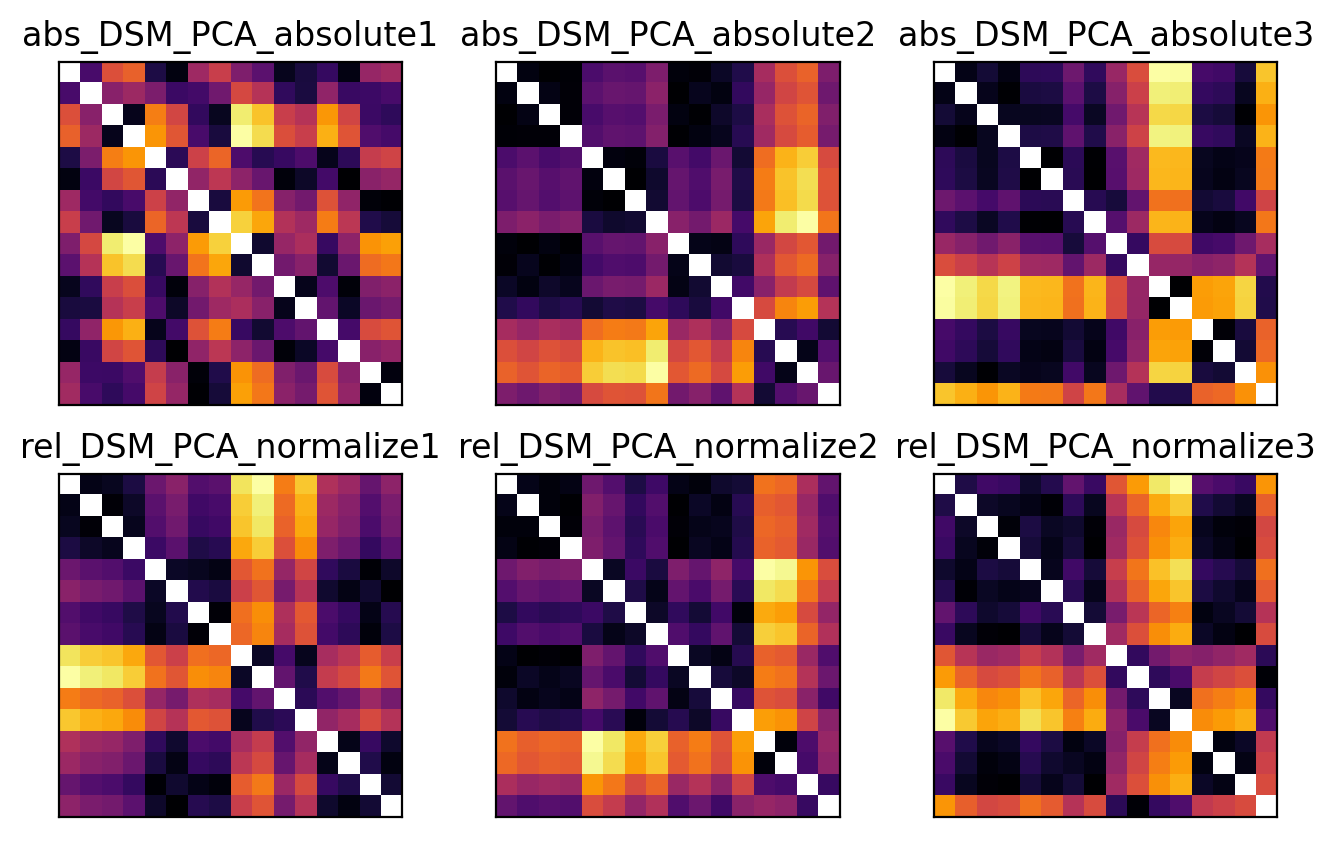

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(8,5), dpi=200)
for dx, descrip in enumerate(stim_rdms.rdm_descriptors['stimulus_model']):
    spec_rdms = stim_rdms.subset('stimulus_model', descrip)
    show_rdm_panel(spec_rdms, ax=axs.flat[dx], rdm_descriptor='stimulus_model', cmap='inferno',)


#### Convert to models

In [13]:
stim_models = []
for dx, descrip in enumerate(stim_rdms.rdm_descriptors['stimulus_model']):
    spec_model = ModelFixed( '{} RDM'.format(descrip), stim_rdms.subset('stimulus_model', descrip))
    stim_models.append(spec_model)

### FFR RDMs


In [14]:
# start with grand average FFR
print('loading FFR dissimilarity matrix')
ffr_rdm_fpath = os.path.join(stim_rdm_dir, 'FFRdistancesgrandavg.csv')
rdm_name = 'FFR_grandavg'
ffr_rdm_data = np.genfromtxt(fpath, delimiter=',', skip_header=1)
print(len(ffr_rdm_data))

# input array needs to be 3-dimensional, despite docs saying 2-D is ok
# (thus the newaxis)
ffr_rdm = RDMs(ffr_rdm_data[np.newaxis,:,:],
               rdm_descriptors={'FFR model': rdm_name},
               pattern_descriptors=pattern_descriptors,
               dissimilarity_measure='Euclidean')
ffr_model = ModelFixed('FFR model', ffr_rdm)

ffr_models = [ffr_model]
    

loading FFR dissimilarity matrix
16


(<Figure size 144x144 with 1 Axes>,
 array([[<AxesSubplot: >]], dtype=object),
 defaultdict(dict,
             {<AxesSubplot: >: {'image': <matplotlib.image.AxesImage at 0x7f6e584f6280>}}))

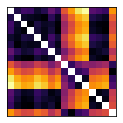

In [15]:
show_rdm(ffr_rdm, cmap='inferno',)

#### Categorical RDMs

In [16]:
# make categorical RDMs
tone_rdm = np.array([[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,], ])

talker_rdm = np.array([[0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ],
                       [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, ],
                       [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, ],
                       [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, ],
                       [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ],
                       [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, ],
                       [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, ],
                       [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, ],
                       [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ],
                       [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, ],
                       [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, ],
                       [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, ],
                       [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ],
                       [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, ],
                       [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, ],
                       [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, ], ])

rdms_array = np.array([tone_rdm, talker_rdm])

In [17]:
cat_rdms = RDMs(rdms_array,
                  rdm_descriptors={'categorical_model':['tone', 'talker'],},
                  pattern_descriptors=pattern_descriptors,
                  dissimilarity_measure='Euclidean'
                 )

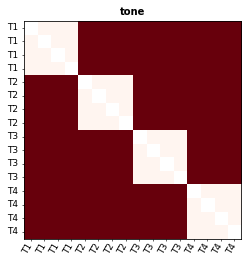

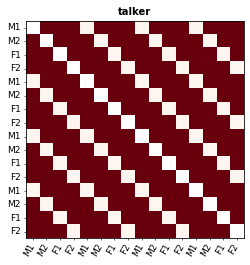

In [18]:
tone_rdms = cat_rdms.subset('categorical_model','tone')
fig, ax, ret_val = show_rdm(tone_rdms, rdm_descriptor='categorical_model', 
                            pattern_descriptor='tone', cmap='Reds', figsize=(4,4))

talker_rdms = cat_rdms.subset('categorical_model','talker')
fig, ax, ret_val = show_rdm(talker_rdms, rdm_descriptor='categorical_model', 
                            pattern_descriptor='talker', cmap='Reds', figsize=(4,4))

In [19]:
cat_rdms.dissimilarities.shape

(2, 120)

#### Convert from RDM to Model

In [20]:
tone_model = ModelFixed( 'Tone RDM', cat_rdms.subset('categorical_model', 'tone'))
talker_model = ModelFixed( 'Talker RDM', cat_rdms.subset('categorical_model', 'talker'))
cat_models = [tone_model, talker_model]

In [21]:
tone_model.name

'Tone RDM'

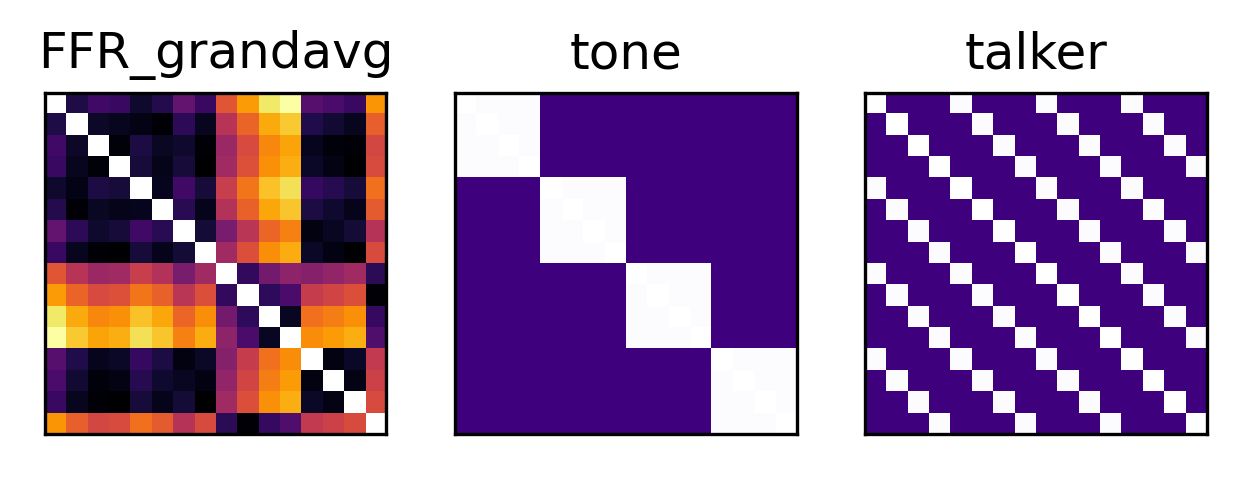

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(5,2), dpi=300)

show_rdm_panel(ffr_rdm, ax=axs.flat[0], rdm_descriptor='FFR model', cmap='inferno',)
show_rdm_panel(tone_rdms, ax=axs.flat[1], rdm_descriptor='categorical_model', cmap='Purples',)
show_rdm_panel(talker_rdms, ax=axs.flat[2], rdm_descriptor='categorical_model', cmap='Purples',)


## Merge model lists

In [23]:
all_models = stim_models + ffr_models + cat_models

In [24]:
[print(x.name) for x in all_models];

abs_DSM_PCA_absolute1 RDM
abs_DSM_PCA_absolute2 RDM
abs_DSM_PCA_absolute3 RDM
rel_DSM_PCA_normalize1 RDM
rel_DSM_PCA_normalize2 RDM
rel_DSM_PCA_normalize3 RDM
FFR model
Tone RDM
Talker RDM


# ROI-based RSA

In [39]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = [
               #'sub-FLT01', 'sub-FLT16',
               #'sub-FLT19', 'sub-FLT20', 
               #'sub-FLT25', 
               #'sub-FLT26', 'sub-FLT28',
                'sub-FLT27', 
                #'sub-FLT30',  
              ]
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index,
                     inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], 
                            ignore_index=True, 
                            inplace=True)

In [40]:
participants_df

participant_id  age sex         group  FFR_id
0       sub-FLT02   21   F  non-Mandarin  1002.0
1       sub-FLT03   25   F      Mandarin  2002.0
2       sub-FLT04   21   F  non-Mandarin  1003.0
3       sub-FLT05   26   M      Mandarin  3010.0
4       sub-FLT06   21   F  non-Mandarin  3001.0
5       sub-FLT07   22   M      Mandarin  2003.0
6       sub-FLT08   23   F      Mandarin  2005.0
7       sub-FLT09   30   F  non-Mandarin  3002.0
8       sub-FLT10   23   F      Mandarin  2006.0
9       sub-FLT11   20   F  non-Mandarin  1005.0
10      sub-FLT12   20   F  non-Mandarin  3004.0
11      sub-FLT13   23   F  non-Mandarin  3005.0
12      sub-FLT14   23   M  non-Mandarin  3006.0
13      sub-FLT15   22   M      Mandarin  2010.0
14      sub-FLT17   29   F      Mandarin     NaN
15      sub-FLT18   24   M      Mandarin  2016.0
16      sub-FLT19   24   M      Mandarin  2018.0
17      sub-FLT20   26   F  non-Mandarin  3008.0
18      sub-FLT21   21   M      Mandarin  2011.0
19      sub-FLT22   41   F      Mandarin  2017.0
20      sub-FLT23   26   F      Mandarin  2013.0
21      sub-FLT24   20   M      Mandarin  2015.0
22      sub-FLT25   19   F  non-Mandarin  2015.0
23      sub-FLT26   23   M      Mandarin     NaN
24      sub-FLT28   23   F  non-Mandarin     NaN
25      sub-FLT30   25   M  non-Mandarin     NaN

In [41]:
# create group-specific lists of subject IDs
sub_group_dict = {'Mandarin': list(participants_df.participant_id[participants_df.group=='Mandarin']),
                  'non-Mandarin': list(participants_df.participant_id[participants_df.group=='non-Mandarin'])}

In [42]:
len(sub_group_dict['Mandarin'])

14

In [43]:
mask_list = [#'mask-L-CN', 'mask-L-SOC', 
             'mask-L-IC', 'mask-L-MGN', 'mask-L-HG', 'mask-L-PP', 'mask-L-PT', 
             'mask-L-STGp', 'mask-L-STGa', 'mask-L-ParsOp', 'mask-L-ParsTri',
             #'mask-R-CN', 'mask-R-SOC', 
             'mask-R-IC', 'mask-R-MGN', 'mask-R-HG', 'mask-R-PP', 'mask-R-PT', 
             'mask-R-STGp', 'mask-R-STGa', 'mask-R-ParsOp', 'mask-R-ParsTri',]

In [44]:
participant_list = participants_df.participant_id
participant_list = [p.split('-')[1] for p in participant_list]
group_assignment = participants_df.group

In [45]:
statmap = 'tstat' # 'beta'

## Run-specific

In [34]:
model_dir

'/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-0.00'

In [48]:
group_rdm_list = []
for sx, sub_id in enumerate(participant_list):
    print(sub_id)
    group_id = group_assignment[sx]

    # set this path to wherever you saved the folder containing the img-files
    model_folder = os.path.join(model_dir, 'masked_statmaps',
                               'sub-{}'.format(sub_id),
                               'statmaps_masked',
                               'stimulus_per_run_LSS')
    for runx, data_folder in enumerate(sorted(glob('{}/run*'.format(model_folder)))):
        #print(data_folder)
        
        #mask_list = np.unique([os.path.basename(x).split('_')[2] for x in all_im_paths])

        all_mask_data = []
        for mx, mask_descrip in enumerate(mask_list):

            #print(mask_descrip)
            image_paths = sorted(glob('{}/{}/*_cond-*_map-{}.csv'.format(data_folder, mask_descrip, statmap)))

            mask_fpath = os.path.join(deriv_dir, 'nilearn', 'masks', 'sub-{}'.format(sub_id),
                                      'space-{}'.format(space_label), 'masks-dseg',
                                      'sub-{}_space-{}_mask-gm.nii.gz'.format(sub_id, space_label))

            try:
                n_vox = np.genfromtxt(image_paths[0]).shape[0]
            except IndexError:
                n_vox = 1

            data = np.zeros((len(image_paths), n_vox))
            for x, im in enumerate(image_paths):
                data[x] = np.genfromtxt(im)
            all_mask_data.append(data)

            roi_rdms = []
        for rx, mask_data in enumerate(all_mask_data):
            dataset = rsatoolbox.data.Dataset(mask_data, 
                                              descriptors={'participant': sub_id, 
                                                           'run': os.path.basename(data_folder),
                                                           'ROI': mask_list[rx], 
                                                           'group': group_id
                                                          },)
            test_rdm = rsatoolbox.rdm.calc_rdm(dataset)
            roi_rdms.append(test_rdm)
            group_rdm_list.append(test_rdm)

        concat_rdms = rsatoolbox.rdm.rdms.concat(roi_rdms)
group_rdms = rsatoolbox.rdm.rdms.concat(group_rdm_list)

FLT02


KeyboardInterrupt: 

In [ ]:
test_rdm

In [ ]:
group_rdms.pattern_descriptors = pattern_descriptors

In [ ]:
np.save('group_run_LSS_rdms', group_rdms, allow_pickle=True)

In [65]:
group_rdms = np.load('group_run__LSS_rdms.npy', allow_pickle=True)

In [70]:
group_rdms

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
None
dissimilarities = 
[]
descriptors = 
{}
rdm_descriptors = 
{'participant': ['FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 

In [101]:
mean_rdms_mand_list = []
mean_rdms_nman_list = []
for runx, run in enumerate(np.unique(group_rdms.rdm_descriptors['run'])):
    for rx, roi in enumerate(mask_list):
        # Mandarin-speaking
        dissim_mand = group_rdms.subset('group', value='Mandarin').subset('run', value=run).subset('ROI', value=roi).dissimilarities

        roi_mand = RDMs(dissim_mand.mean(axis=0),
                        rdm_descriptors={'run': run, 'ROI': mask_list[rx], 'group': 'Mandarin'},
                        pattern_descriptors=pattern_descriptors)
        mean_rdms_mand_list.append(roi_mand)

        # non-Mandarin-speaking
        dissim_nman = group_rdms.subset('group', value='non-Mandarin').subset('run', value=run).subset('ROI', value=roi).dissimilarities
        roi_nman = RDMs(dissim_nman.mean(axis=0),
                        rdm_descriptors={'run': run, 'ROI': mask_list[rx], 'group': 'non-Mandarin'},
                        pattern_descriptors=pattern_descriptors)
        mean_rdms_nman_list.append(roi_nman)

mean_rdms_mand = rsatoolbox.rdm.rdms.concat(mean_rdms_mand_list)
mean_rdms_nman = rsatoolbox.rdm.rdms.concat(mean_rdms_nman_list)



In [102]:
roi_nman

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
None
dissimilarities = 
[[ 1720.24063129  1720.34272514  1441.3127721   3509.45244581
   3590.17647989 20119.46535274  2537.09950716  2765.58285075
   2975.6078739   2313.80429068  3243.57996593  2185.63037562
   2149.08516846  1992.01590549  1730.54024121  1898.99983143
   1666.61974606  3215.4078944   3101.287001   17296.77542613
   2597.35755334  2588.96647854  2936.13381402  2942.7761211
   3469.30521401  3058.31280393  2585.3409436   2357.19210347
   2041.11450185  1806.45191746  3223.16025331  3114.21402891
  17165.11401434  2377.28241011  2577.90504183  2741.4864684
   2603.57684464  3067.23797149  2480.42770741  2429.68975542
   2057.16375908  2034.35376004  2840.83005577  2646.11046221
  16821.47068853  2354.19486764  2058.95085135  2251.23562537
   2174.67622932  2775.88349085  1628.91395525  2127.12524305
   2380.27208132  1813.37861704  1965.48407725 11322.3696644
   1741.08410442  2560.49710947  3385.59650876  3601.04496621
   

In [103]:
len(dissim_nman.mean(axis=0))

120

In [104]:
len(mean_rdms_nman_list)

108

In [105]:
len(mean_rdms_nman)

108

NameError: name 'mean_rdms_mand' is not defined

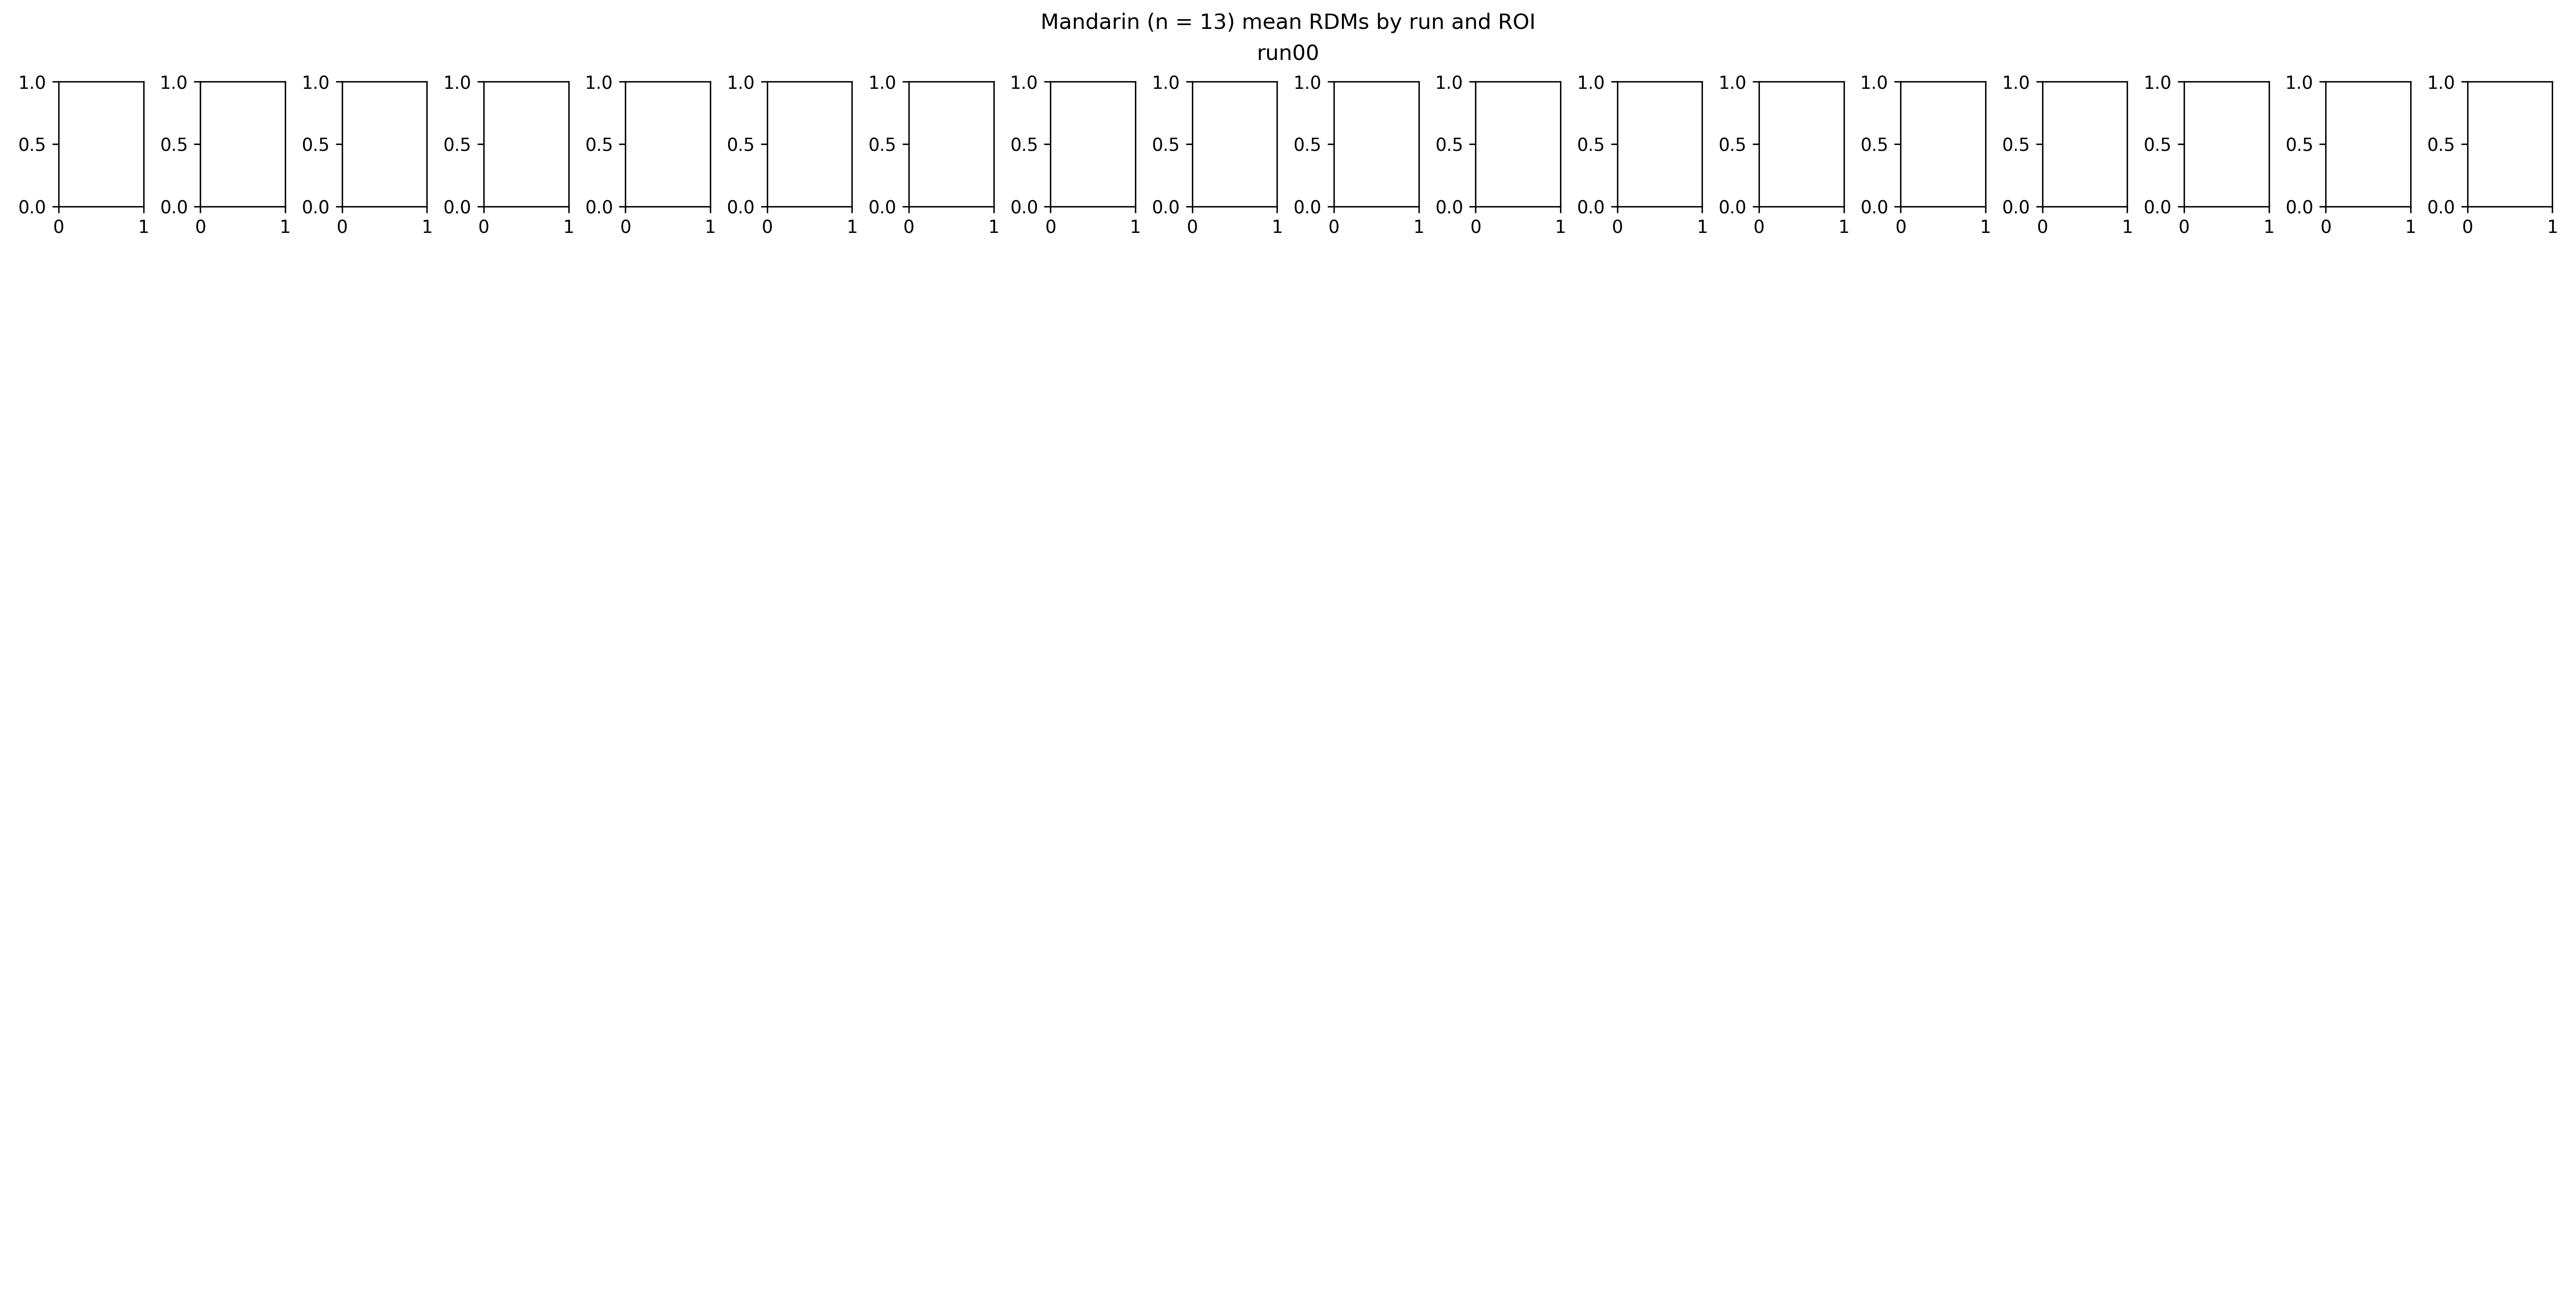

In [71]:
n_mand = len(sub_group_dict['Mandarin'])

fig = plt.figure(constrained_layout=True, figsize=(20,10), dpi=300)
fig.suptitle('Mandarin (n = {}) mean RDMs by run and ROI'.format(n_mand))

subfigs = fig.subfigures(nrows=6, ncols=1)


for sf, run in enumerate(np.unique(group_rdms.rdm_descriptors['run'])):
    subfigs[sf].suptitle(run)

    axs = subfigs[sf].subplots(nrows=1, ncols=len(mask_list))
    for rx, roi in enumerate(mask_list):
        rsatoolbox.vis.show_rdm_panel(mean_rdms_mand.subset('run', value=run).subset('ROI', value=roi), 
                                      rdm_descriptor='ROI', 
                                      cmap='inferno', 
                                      ax=axs[rx])

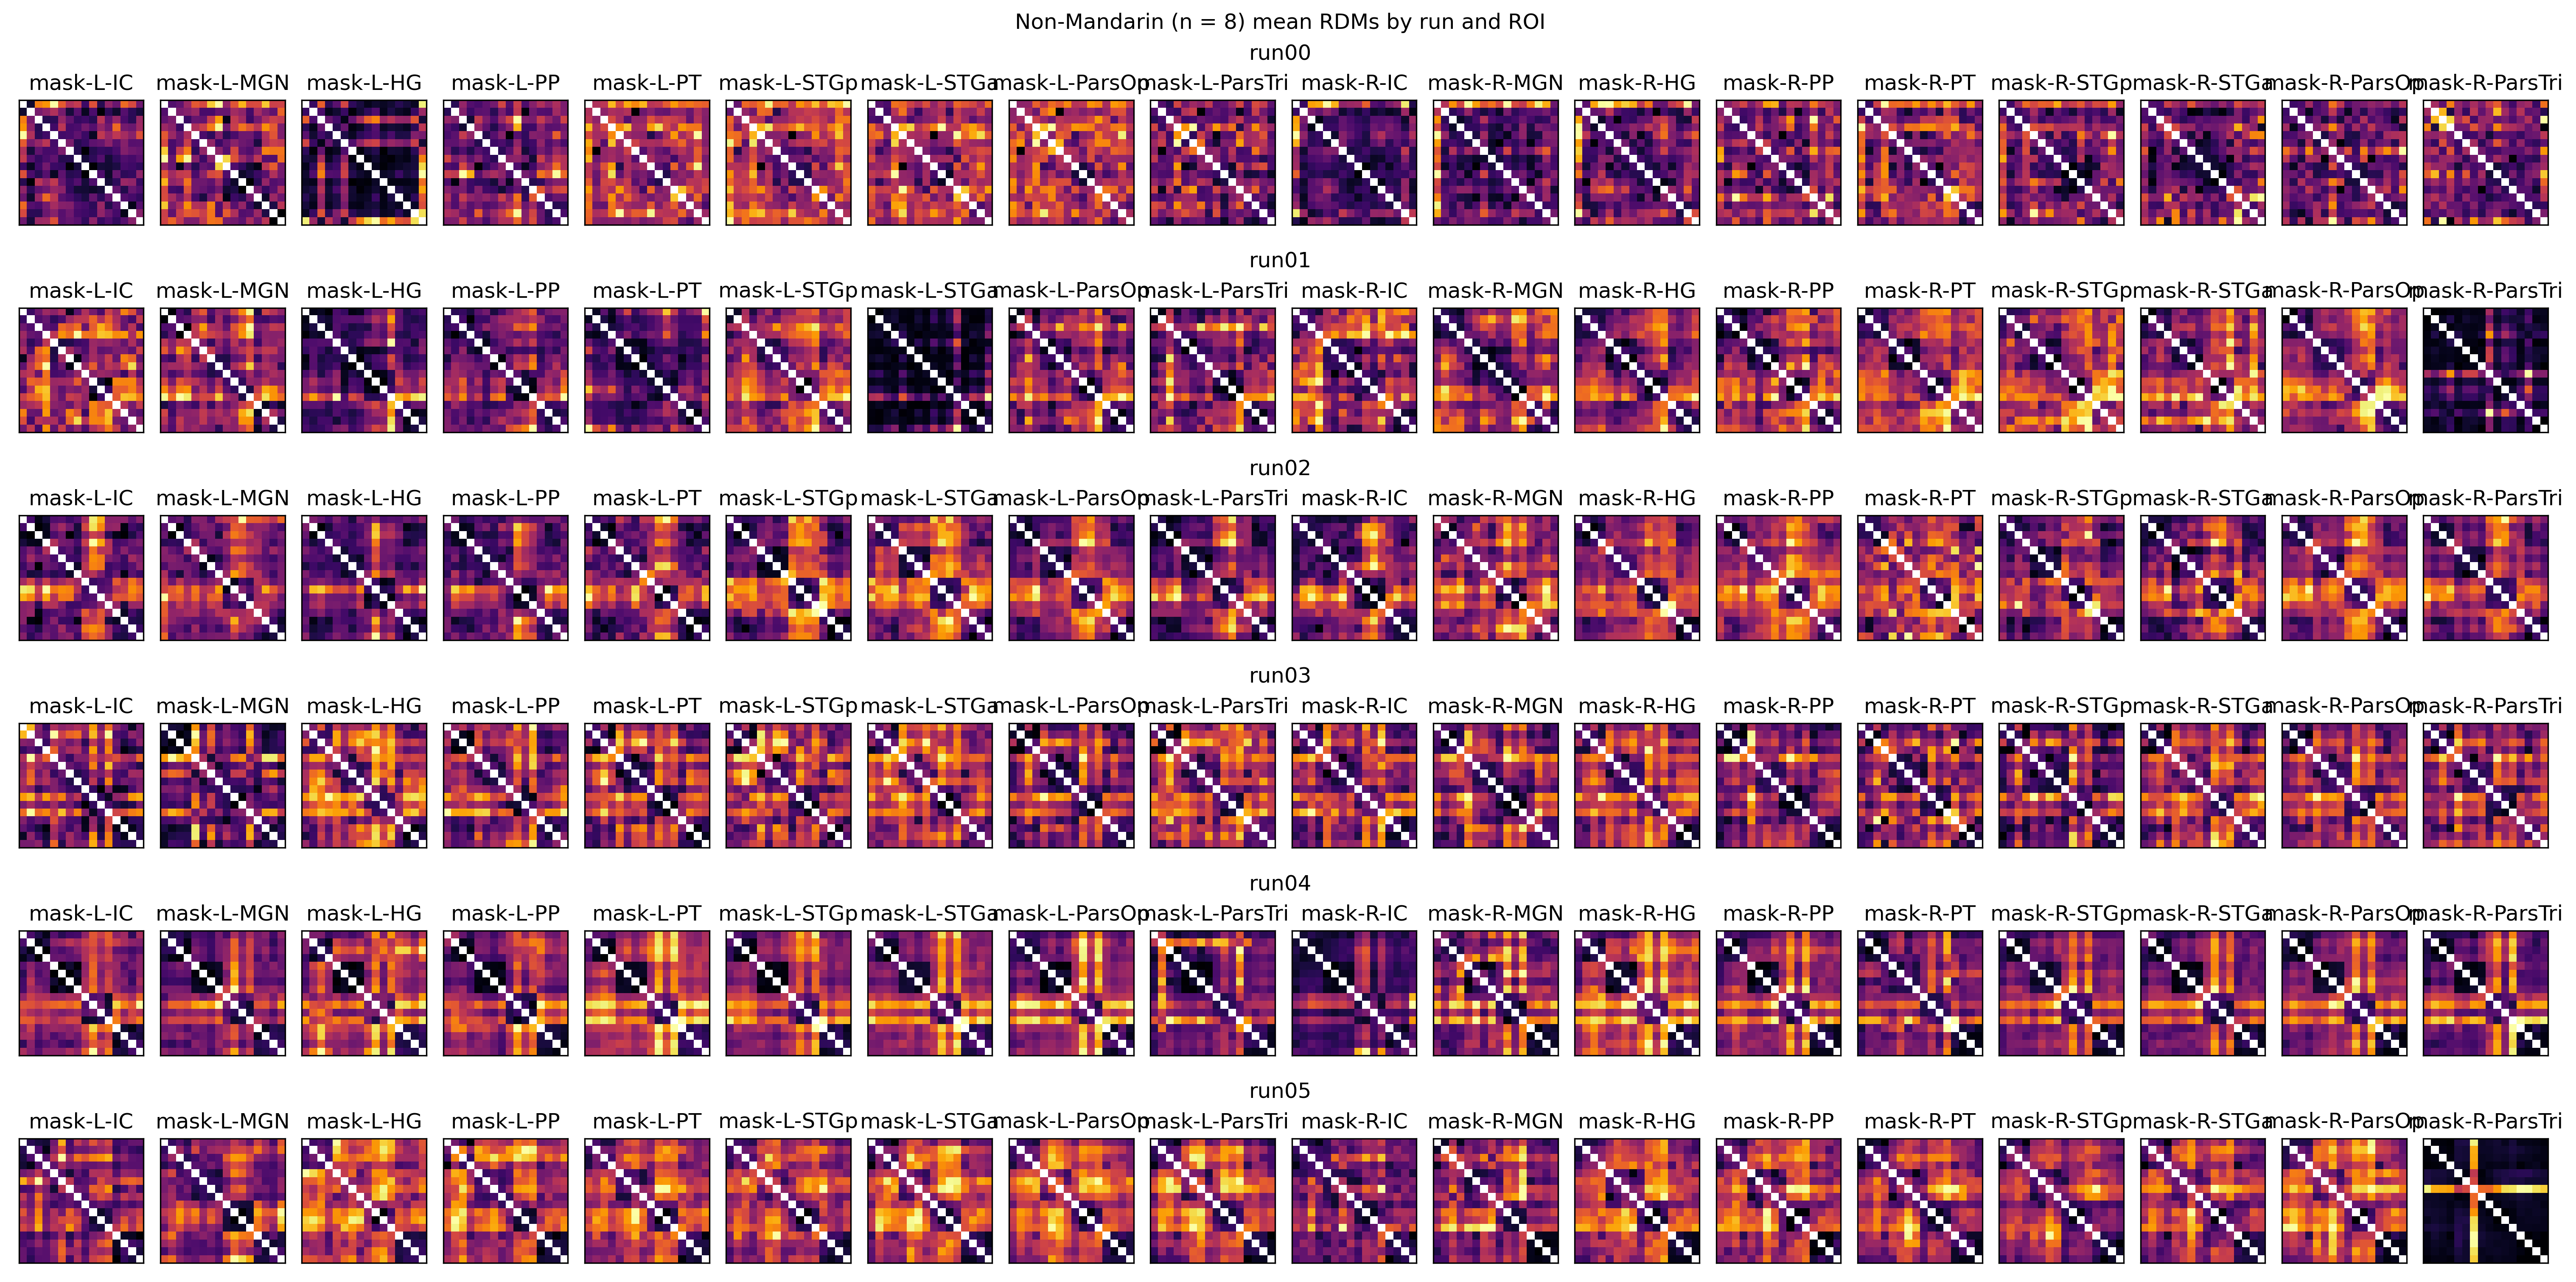

In [110]:
n_nman = len(sub_group_dict['non-Mandarin'])

fig = plt.figure(constrained_layout=True, figsize=(20,10), dpi=300)
fig.suptitle('Non-Mandarin (n = {}) mean RDMs by run and ROI'.format(n_nman))

subfigs = fig.subfigures(nrows=6, ncols=1)

for sf, run in enumerate(np.unique(group_rdms.rdm_descriptors['run'])):
    subfigs[sf].suptitle(run)

    axs = subfigs[sf].subplots(nrows=1, ncols=len(mask_list))
    for rx, roi in enumerate(mask_list):
        rsatoolbox.vis.show_rdm_panel(mean_rdms_nman.subset('run', value=run).subset('ROI', value=roi), 
                                      rdm_descriptor='ROI', 
                                      cmap='inferno', 
                                      ax=axs[rx])

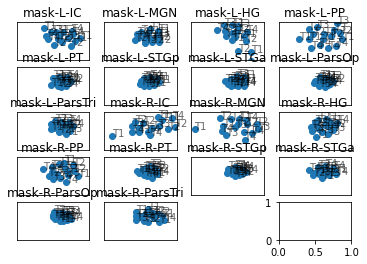

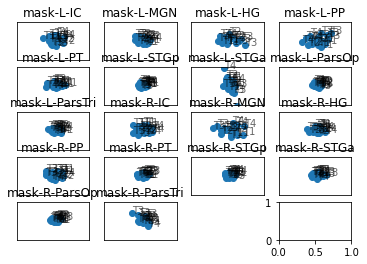

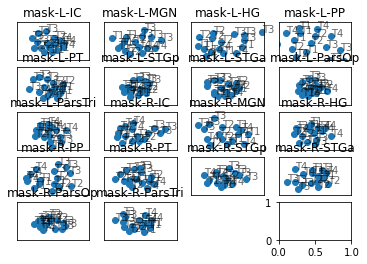

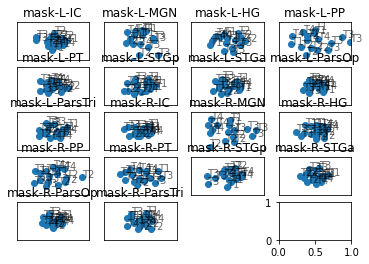

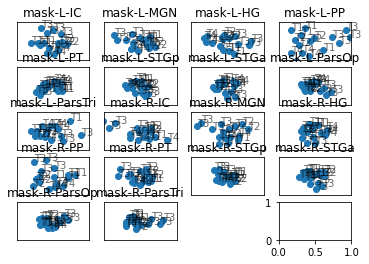

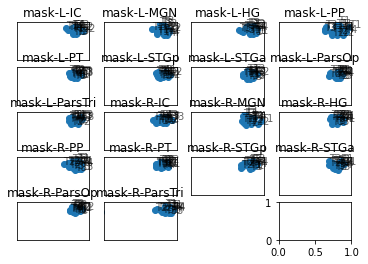

In [113]:
for sf, run in enumerate(np.unique(group_rdms.rdm_descriptors['run'])):
    rsatoolbox.vis.scatter_plot.show_MDS(mean_rdms_nman.subset('run', run), 
                                         rdm_descriptor='ROI',
                                         pattern_descriptor='tone');

### Run-specific RSA

## Run-all

In [46]:
group_rdm_list = []
for sx, sub_id in enumerate(participant_list):
    print(sub_id)
    group_id = group_assignment[sx]

    # set this path to wherever you saved the folder containing the img-files
    data_folder = os.path.join(model_dir, 'masked_statmaps',
                               'sub-{}'.format(sub_id),
                               'statmaps_masked',
                               'run-all_LSS')

    all_im_paths = sorted(glob('{}/*mask-*_cond-*_map-{}.csv'.format(data_folder, statmap)))
    #mask_list = np.unique([os.path.basename(x).split('_')[2] for x in all_im_paths])

    all_mask_data = []
    for mx, mask_descrip in enumerate(mask_list):

        print(mask_descrip)
        image_paths = sorted(glob('{}/*{}*/*{}*_cond-*_map-{}.csv'.format(data_folder, mask_descrip, mask_descrip, statmap)))
        #print('# of images: ', len(image_paths))

        mask_fpath = os.path.join(deriv_dir, 'nilearn', 'masks', 'sub-{}'.format(sub_id),
                                  'space-{}'.format(space_label), 'masks-dseg',
                                  'sub-{}_space-{}_mask-gm.nii.gz'.format(sub_id, space_label))

        try:
            n_vox = np.genfromtxt(image_paths[0]).shape[0]
        except IndexError:
            n_vox = 1

        data = np.zeros((len(image_paths), n_vox))
        for x, im in enumerate(image_paths):
            data[x] = np.genfromtxt(im)
        all_mask_data.append(data)

        roi_rdms = []
    for rx, mask_data in enumerate(all_mask_data):
        dataset = rsatoolbox.data.Dataset(mask_data, 
                                          descriptors={'participant': sub_id, 
                                                       'ROI': mask_list[rx], 
                                                       'group': group_id
                                                      },)
        test_rdm = rsatoolbox.rdm.calc_rdm(dataset)
        roi_rdms.append(test_rdm)
        group_rdm_list.append(test_rdm)

    concat_rdms = rsatoolbox.rdm.rdms.concat(roi_rdms)
group_rdms = rsatoolbox.rdm.rdms.concat(group_rdm_list)

FLT02
mask-L-IC
mask-L-MGN
mask-L-HG
mask-L-PP
mask-L-PT
mask-L-STGp
mask-L-STGa
mask-L-ParsOp
mask-L-ParsTri
mask-R-IC
mask-R-MGN
mask-R-HG
mask-R-PP
mask-R-PT
mask-R-STGp
mask-R-STGa
mask-R-ParsOp
mask-R-ParsTri
FLT03
mask-L-IC
mask-L-MGN
mask-L-HG
mask-L-PP
mask-L-PT
mask-L-STGp
mask-L-STGa
mask-L-ParsOp
mask-L-ParsTri
mask-R-IC
mask-R-MGN
mask-R-HG
mask-R-PP
mask-R-PT
mask-R-STGp
mask-R-STGa
mask-R-ParsOp
mask-R-ParsTri
FLT04
mask-L-IC
mask-L-MGN
mask-L-HG
mask-L-PP
mask-L-PT
mask-L-STGp
mask-L-STGa
mask-L-ParsOp
mask-L-ParsTri
mask-R-IC
mask-R-MGN
mask-R-HG
mask-R-PP
mask-R-PT
mask-R-STGp
mask-R-STGa
mask-R-ParsOp
mask-R-ParsTri
FLT05
mask-L-IC
mask-L-MGN
mask-L-HG
mask-L-PP
mask-L-PT
mask-L-STGp
mask-L-STGa
mask-L-ParsOp
mask-L-ParsTri
mask-R-IC
mask-R-MGN
mask-R-HG
mask-R-PP
mask-R-PT
mask-R-STGp
mask-R-STGa
mask-R-ParsOp
mask-R-ParsTri
FLT06
mask-L-IC
mask-L-MGN
mask-L-HG
mask-L-PP
mask-L-PT
mask-L-STGp
mask-L-STGa
mask-L-ParsOp
mask-L-ParsTri
mask-R-IC
mask-R-MGN
mask-R-HG
mas

In [55]:
roi_rdms

[]

In [51]:
group_rdms.pattern_descriptors = pattern_descriptors

In [52]:
group_rdms

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
None
dissimilarities = 
[[1.40924999 2.66325461 1.84505286 ... 1.7088736  1.33167823 0.8592301 ]
 [2.21237098 2.14950354 1.62948563 ... 1.4023714  1.91698068 1.93859945]
 [2.32618513 2.63939258 2.42970105 ... 1.59993947 1.63449709 1.56709288]
 ...
 [1.98361573 1.7192756  2.00921907 ... 1.97944517 2.19677555 2.31836048]
 [1.88566946 1.94517668 2.27990385 ... 1.90193625 2.50595614 2.71935543]
 [1.70656198 1.86069334 2.2127061  ... 1.80834721 2.68662181 3.0224045 ]]
descriptors = 
{}
rdm_descriptors = 
{'participant': ['FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT04', 'FLT04', 'FLT04', 'FLT04', 'FLT04', 'FLT04', 'FLT04', 'FLT04', 'FLT04', 'FLT04', 'FLT04', 'FLT04', 

In [53]:
fig = plt.figure(constrained_layout=True, figsize=(20,30), dpi=500)
fig.suptitle('Single-participant ROI RDMs')

subfigs = fig.subfigures(nrows=len(participant_list), ncols=1)

for sx, sub_id in enumerate(participant_list):
    subfigs[sx].suptitle(f'{sub_id} - {group_assignment[sx]} group')
    axes = subfigs[sx].subplots(nrows=1, ncols=len(mask_list))
    for rx, roi in enumerate(mask_list):
        rsatoolbox.vis.show_rdm_panel(group_rdms.subset('participant', value=sub_id).subset('ROI', value=roi), 
                                        ax=axes[rx],
                                        rdm_descriptor='ROI', 
                                        cmap='inferno',
                                        #show_colorbar='panel', # cut figsize height in half if showing colorbar
                                       );


#### Mean RDMs across participants per group

In [54]:
mean_rdms_mand_list = []
mean_rdms_nman_list = []
for rx, roi in enumerate(mask_list):
    # Mandarin-speaking
    dissim_mand = group_rdms.subset('group', value='Mandarin').subset('ROI', value=roi).dissimilarities
    
    roi_mand = RDMs(dissim_mand.mean(axis=0),
                    rdm_descriptors={'ROI': mask_list[rx], 'group': 'Mandarin'},
                    pattern_descriptors=pattern_descriptors)
    mean_rdms_mand_list.append(roi_mand)
    
    # non-Mandarin-speaking
    dissim_nman = group_rdms.subset('group', value='non-Mandarin').subset('ROI', value=roi).dissimilarities
    roi_nman = RDMs(dissim_nman.mean(axis=0),
                    rdm_descriptors={'ROI': mask_list[rx], 'group': 'non-Mandarin'},
                    pattern_descriptors=pattern_descriptors)
    mean_rdms_nman_list.append(roi_nman)

mean_rdms_mand = rsatoolbox.rdm.rdms.concat(mean_rdms_mand_list)
mean_rdms_nman = rsatoolbox.rdm.rdms.concat(mean_rdms_nman_list)



In [56]:
mean_rdms_nman

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
None
dissimilarities = 
[[2.38902109 2.63207205 2.34004519 ... 2.73256195 2.24161509 2.77280507]
 [2.40617473 2.10557781 2.17536334 ... 2.1792102  1.86388909 2.13165379]
 [2.22606838 2.31354881 2.39014602 ... 2.19775741 2.22173574 2.26882122]
 ...
 [2.02288878 2.18723457 2.15537475 ... 2.06074714 2.11972084 2.10085046]
 [2.03048418 2.19110332 2.20170728 ... 2.08244188 2.11514586 2.3192096 ]
 [1.97471774 2.03945699 2.18875005 ... 2.1347646  2.08425169 2.15577791]]
descriptors = 
{}
rdm_descriptors = 
{'ROI': ['mask-L-IC', 'mask-L-MGN', 'mask-L-HG', 'mask-L-PP', 'mask-L-PT', 'mask-L-STGp', 'mask-L-STGa', 'mask-L-ParsOp', 'mask-L-ParsTri', 'mask-R-IC', 'mask-R-MGN', 'mask-R-HG', 'mask-R-PP', 'mask-R-PT', 'mask-R-STGp', 'mask-R-STGa', 'mask-R-ParsOp', 'mask-R-ParsTri'], 'group': ['non-Mandarin', 'non-Mandarin', 'non-Mandarin', 'non-Mandarin', 'non-Mandarin', 'non-Mandarin', 'non-Mandarin', 'non-Mandarin', 'non-Mandarin', 'non-Mandarin', 'non-Ma

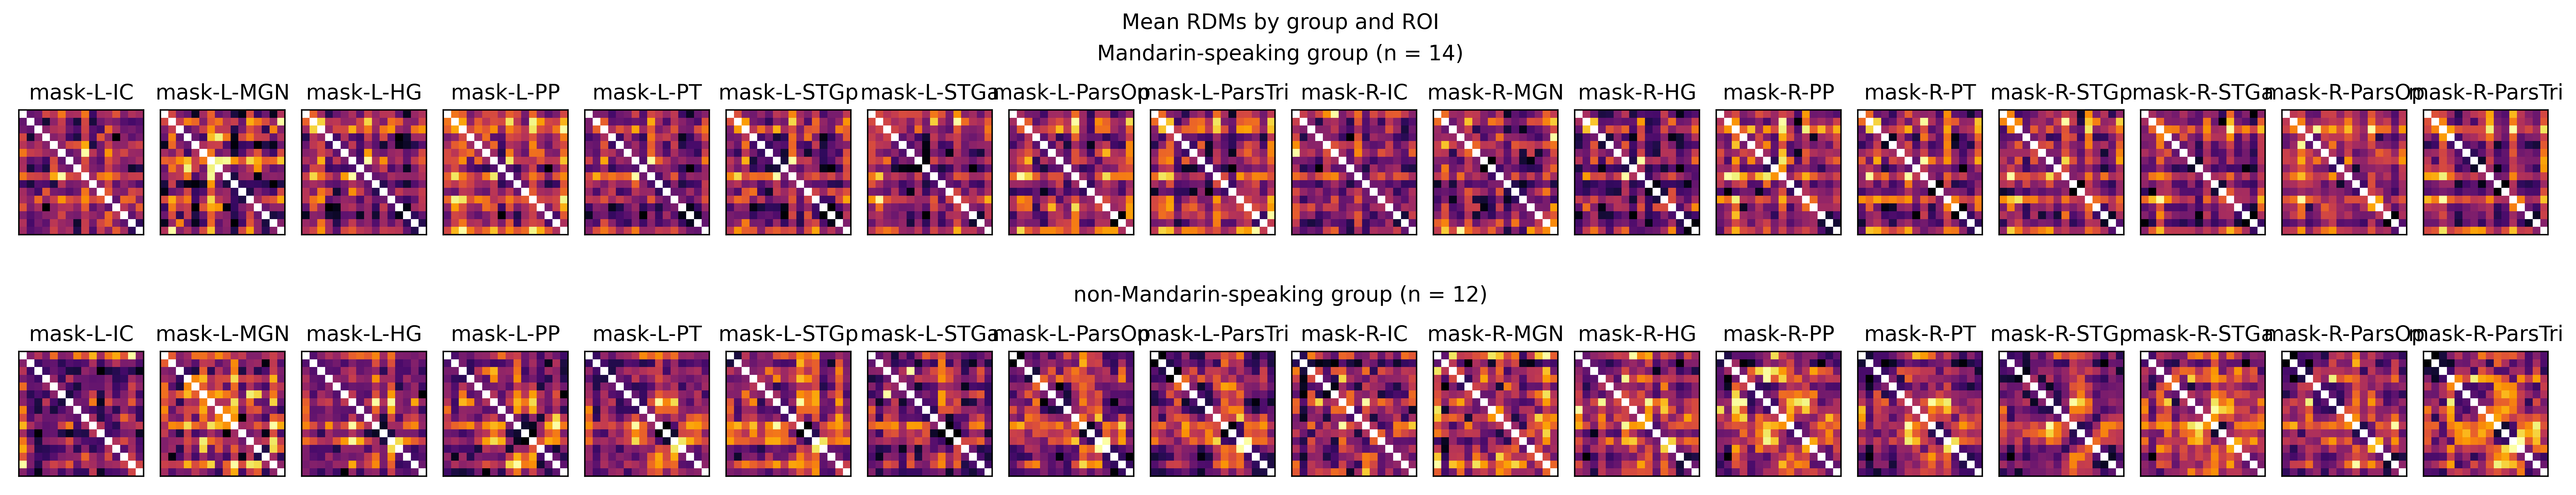

In [75]:
fig = plt.figure(constrained_layout=True, figsize=(20,4), dpi=500)
fig.suptitle('Mean RDMs by group and ROI')

subfigs = fig.subfigures(nrows=2, ncols=1)

n_mand = len(sub_group_dict['Mandarin'])
n_nman = len(sub_group_dict['non-Mandarin'])

subfigs[0].suptitle(f'Mandarin-speaking group (n = {n_mand})')
subfigs[1].suptitle(f'non-Mandarin-speaking group (n = {n_nman})')

axs0 = subfigs[0].subplots(nrows=1, ncols=len(mask_list))
axs1 = subfigs[1].subplots(nrows=1, ncols=len(mask_list))
for rx, roi in enumerate(mask_list):
    rsatoolbox.vis.show_rdm_panel(mean_rdms_mand.subset('ROI', value=roi), 
                                  rdm_descriptor='ROI', 
                                  cmap='inferno', 
                                  ax=axs0[rx])
    rsatoolbox.vis.show_rdm_panel(mean_rdms_nman.subset('ROI', value=roi), 
                                  rdm_descriptor='ROI', 
                                  cmap='inferno', 
                                  ax=axs1[rx])

#### MDS

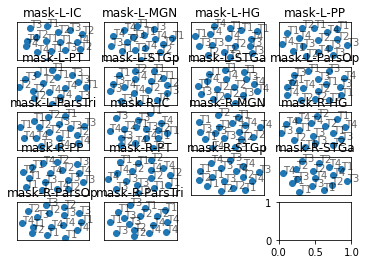

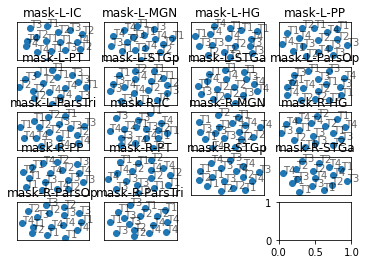

In [58]:
rsatoolbox.vis.scatter_plot.show_MDS(mean_rdms_mand, 
                                     rdm_descriptor='ROI',
                                     pattern_descriptor='tone')

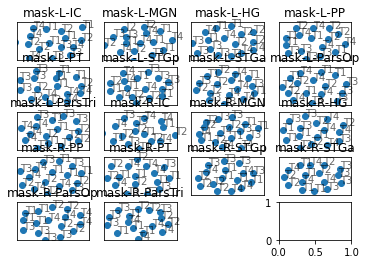

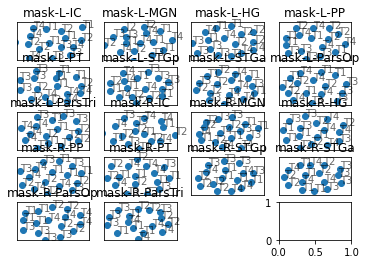

In [59]:
rsatoolbox.vis.scatter_plot.show_MDS(mean_rdms_nman, 
                                     rdm_descriptor='ROI',
                                     pattern_descriptor='tone')

### Stim model comparisons

(<Figure size 900x720 with 2 Axes>, <Axes: >, <Axes: >)

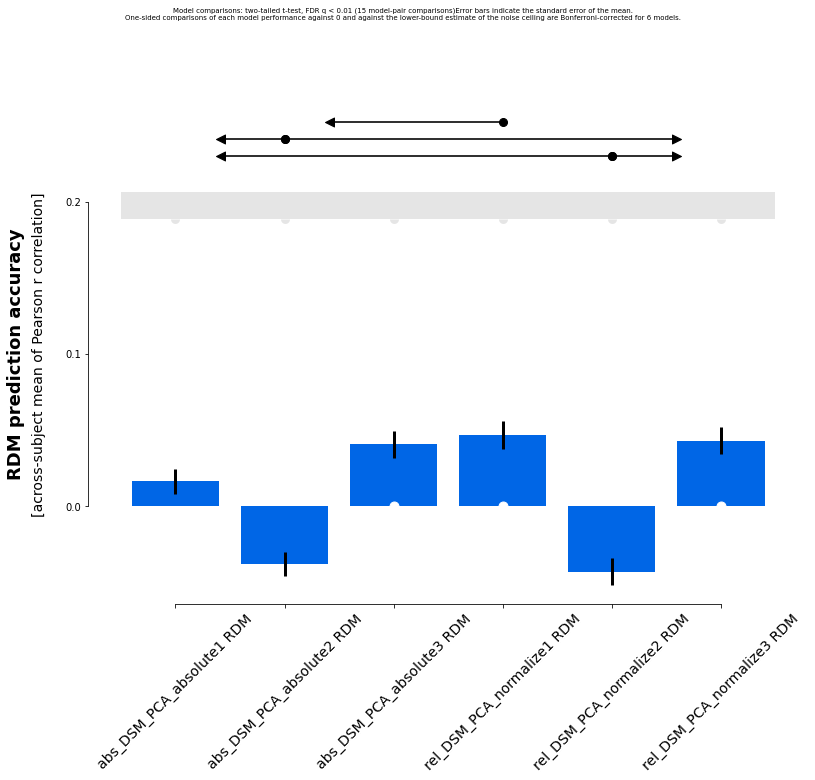

In [60]:
results_all = rsatoolbox.inference.eval_fixed(stim_models, group_rdms.subset('group', value='Mandarin'),  method='corr',)
rsatoolbox.vis.plot_model_comparison(results_all)

(<Figure size 900x720 with 2 Axes>, <Axes: >, <Axes: >)

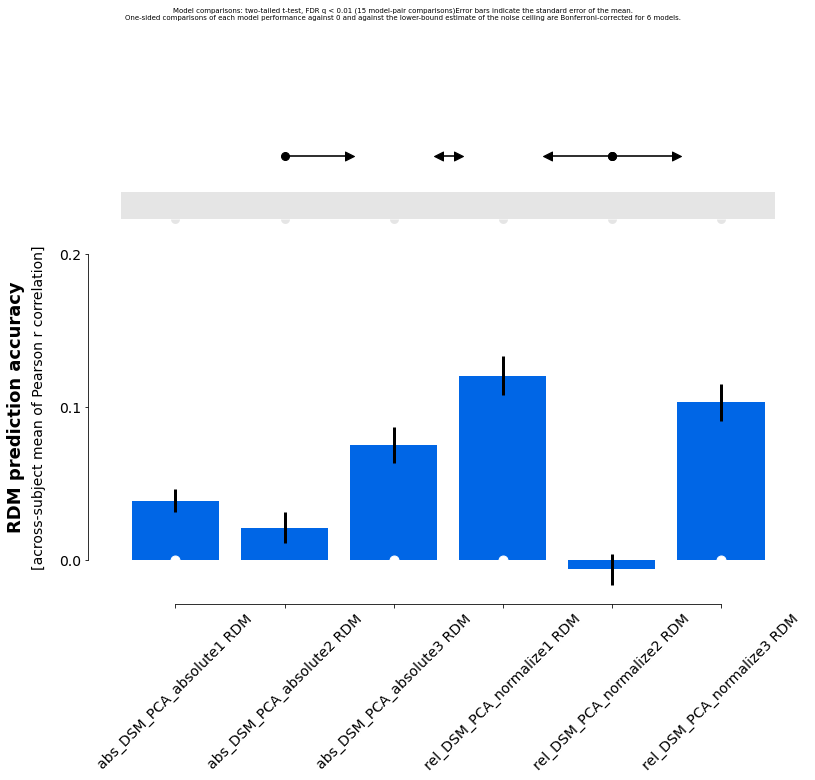

In [61]:
results_all = rsatoolbox.inference.eval_fixed(stim_models, group_rdms.subset('group', value='non-Mandarin'),  method='corr',)
rsatoolbox.vis.plot_model_comparison(results_all)

<Figure size 432x288 with 0 Axes>

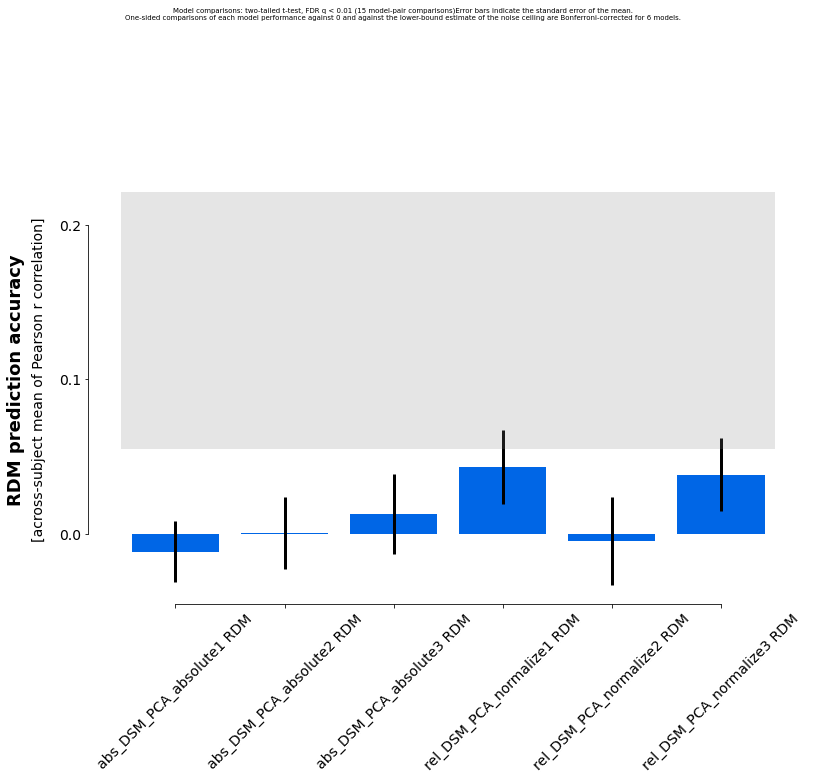

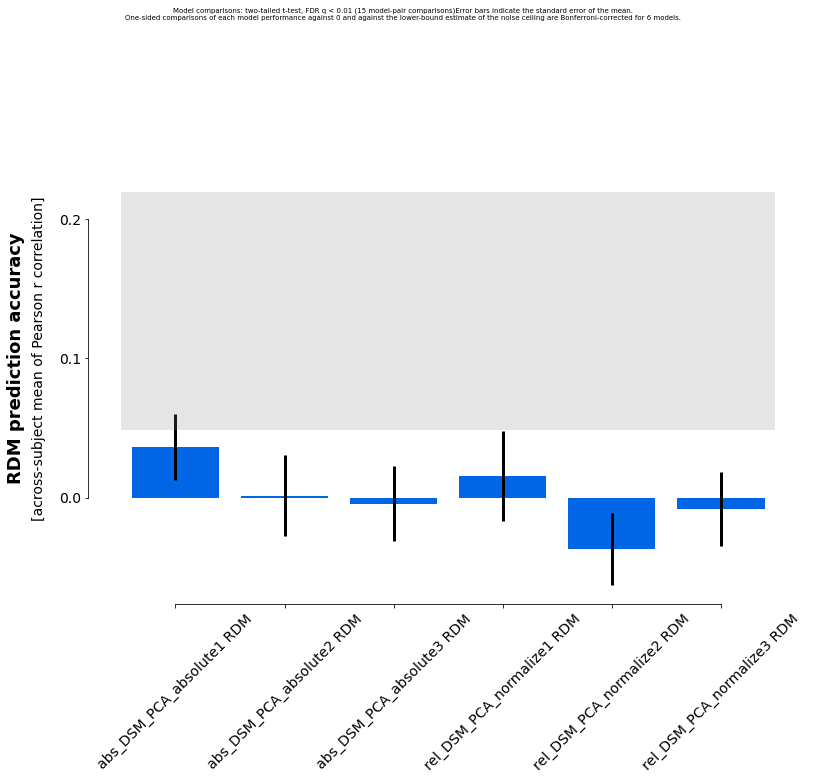

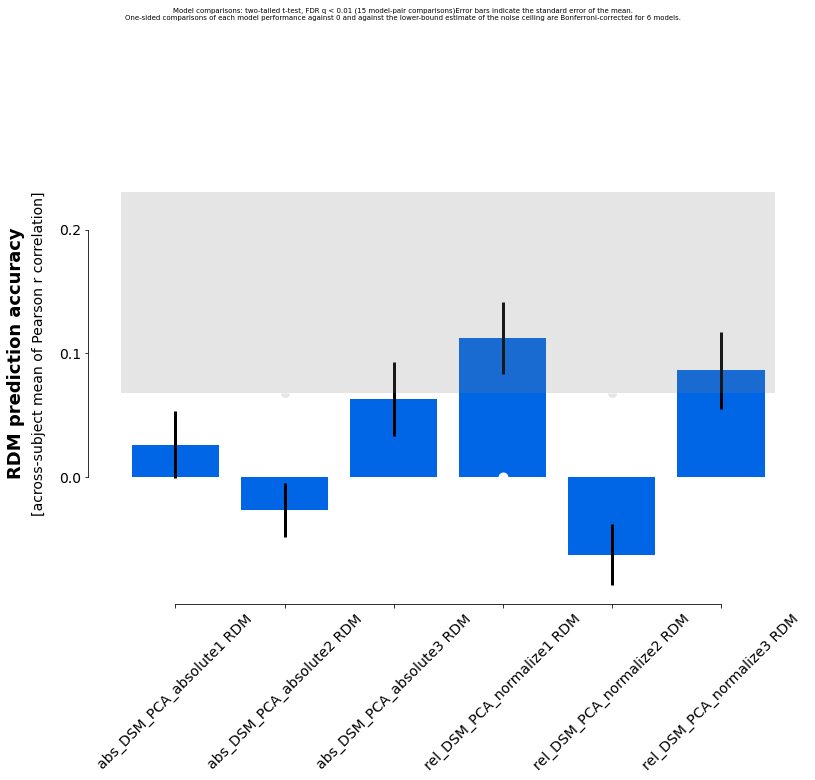

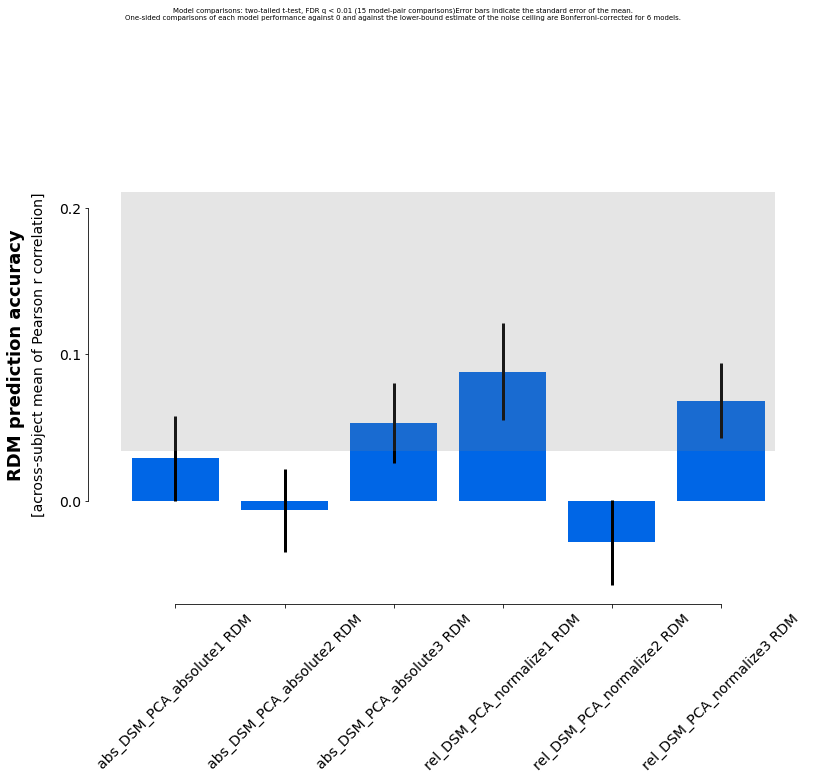

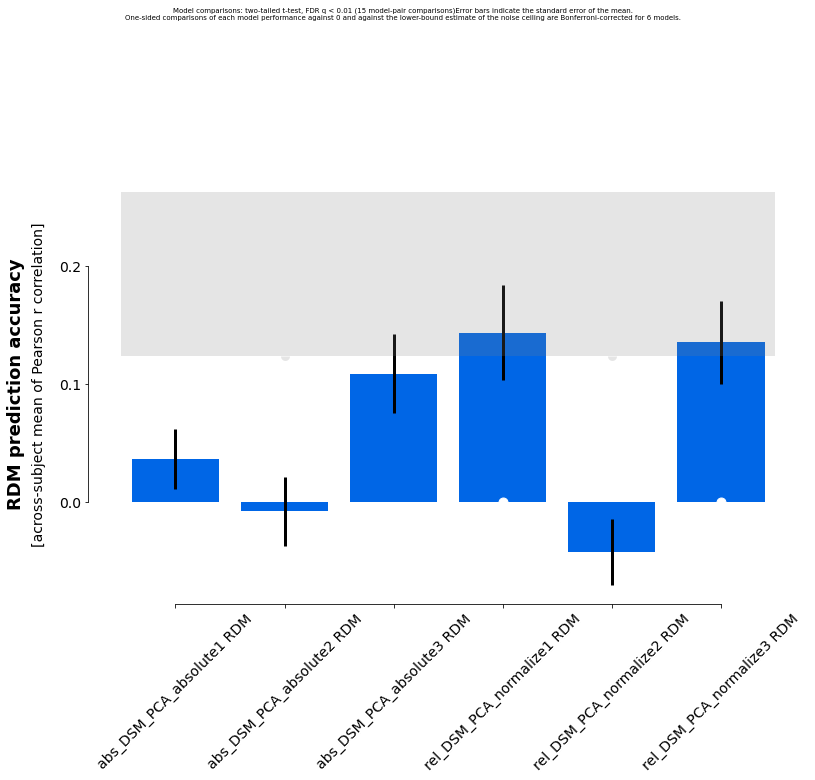

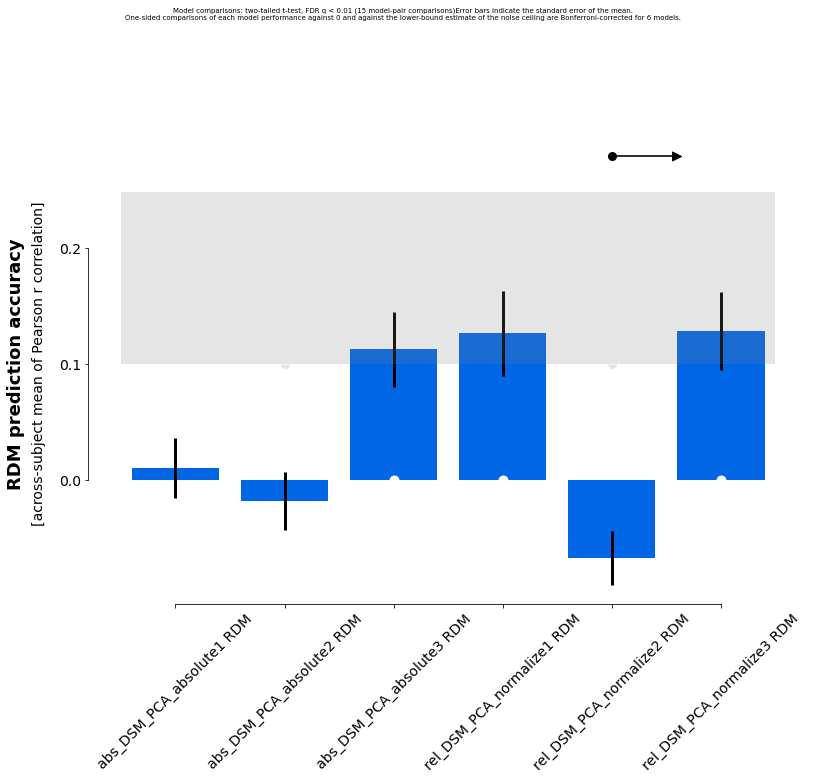

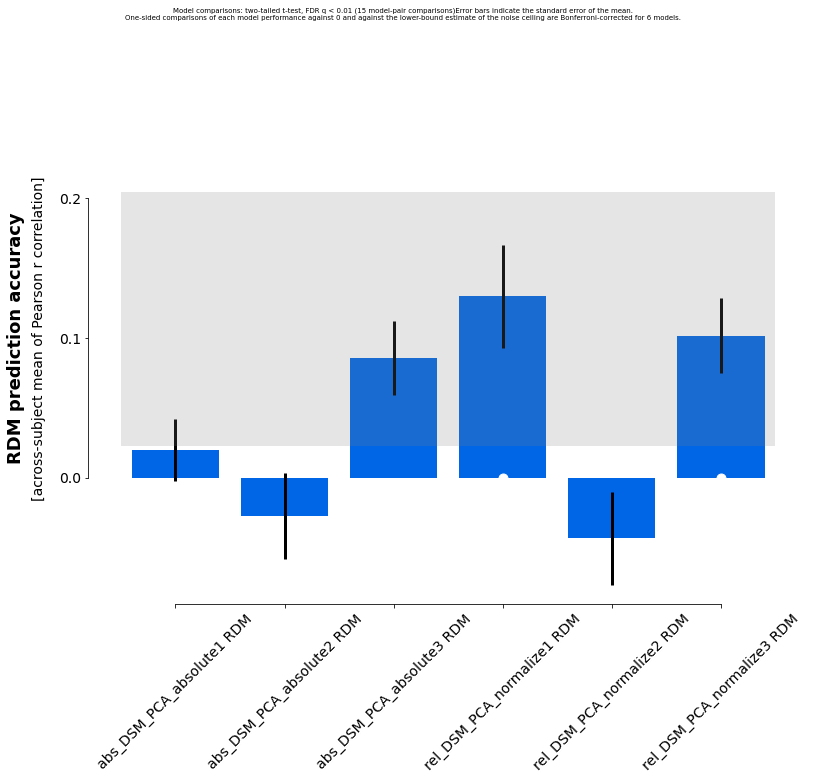

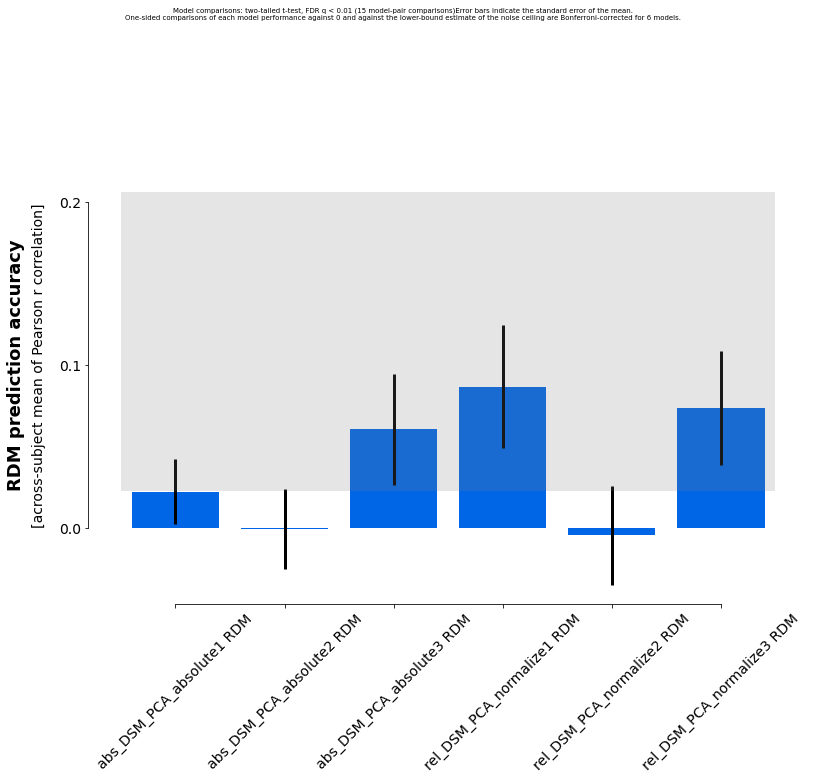

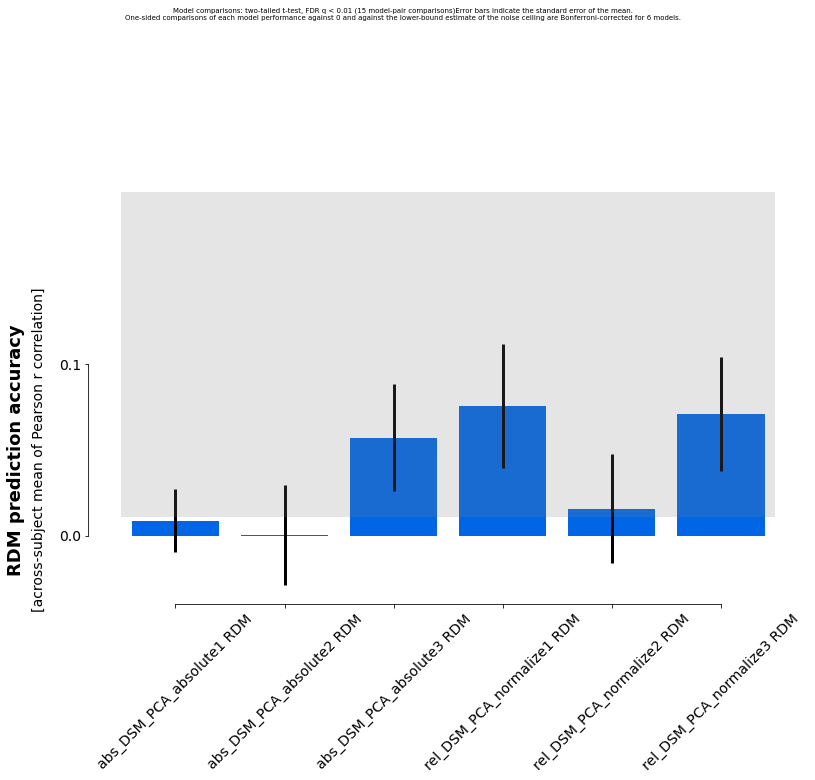

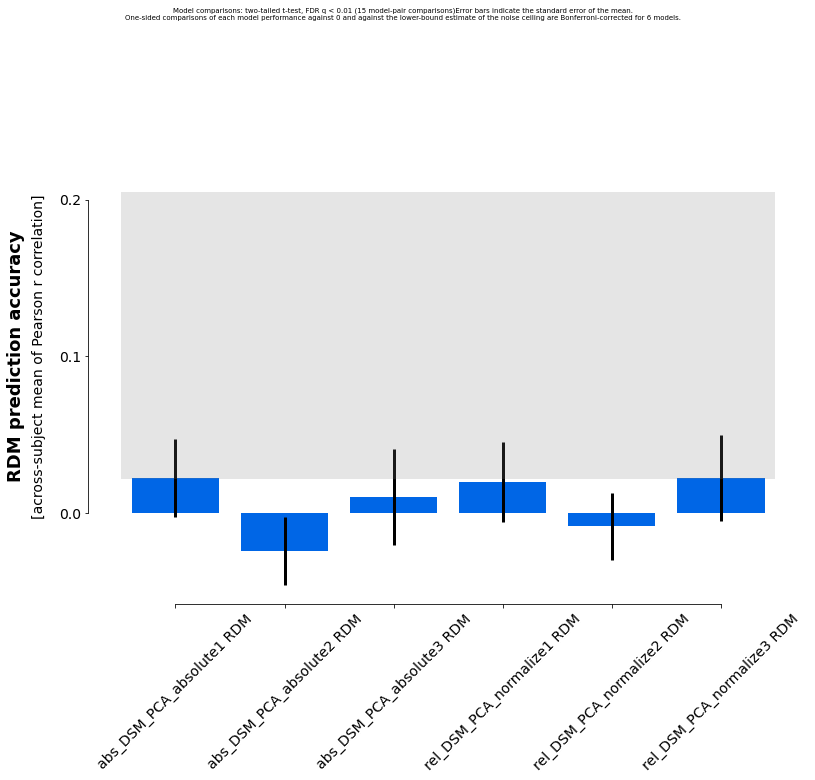

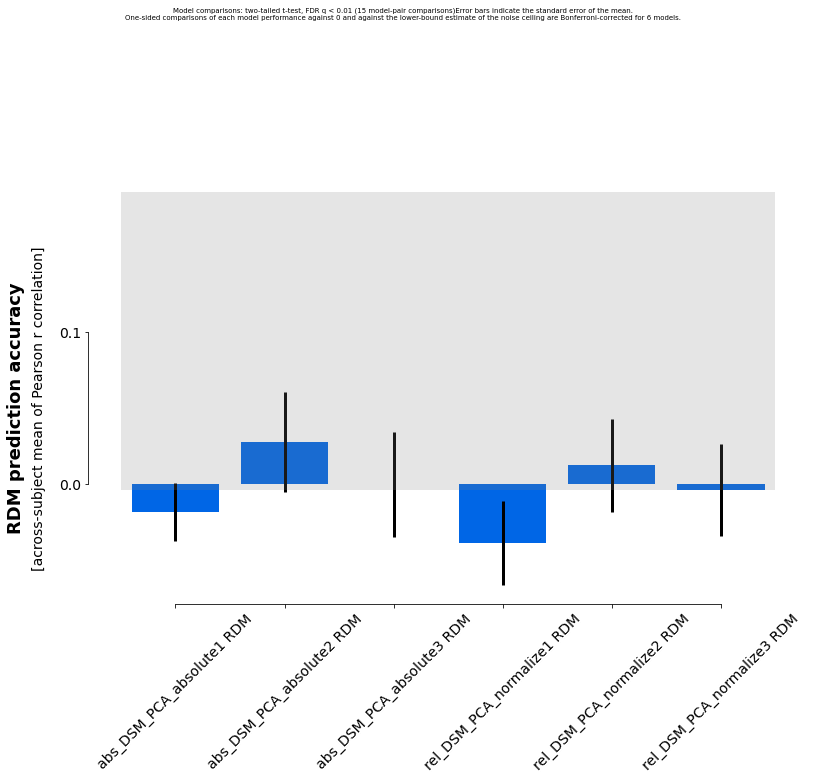

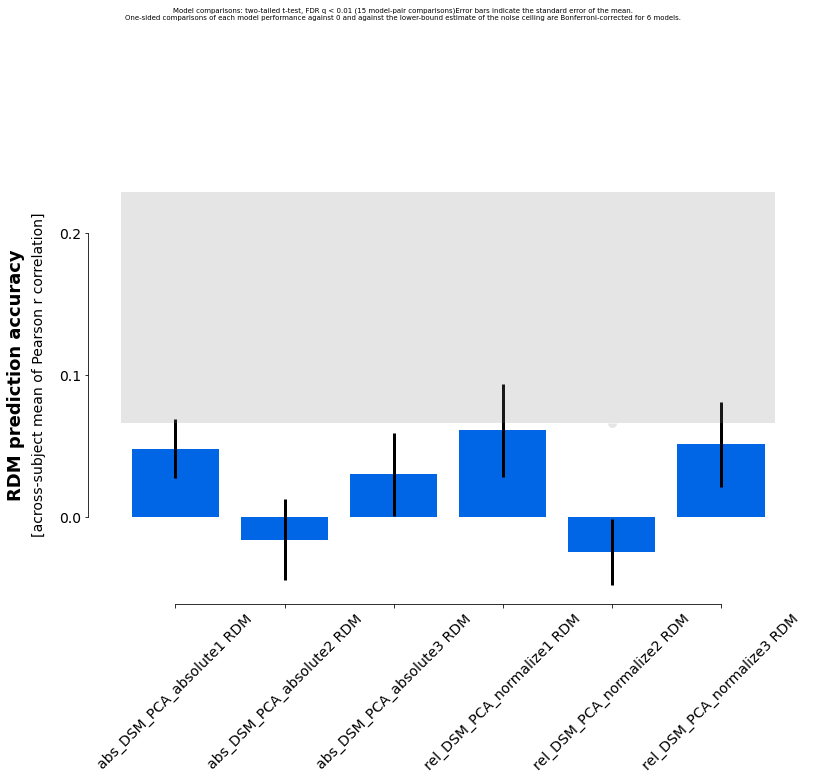

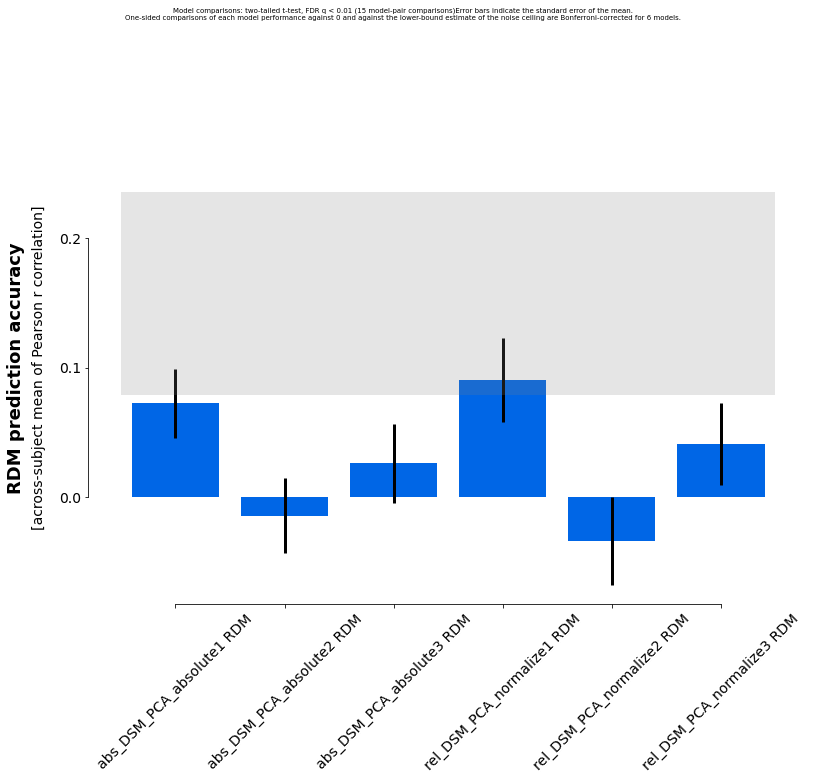

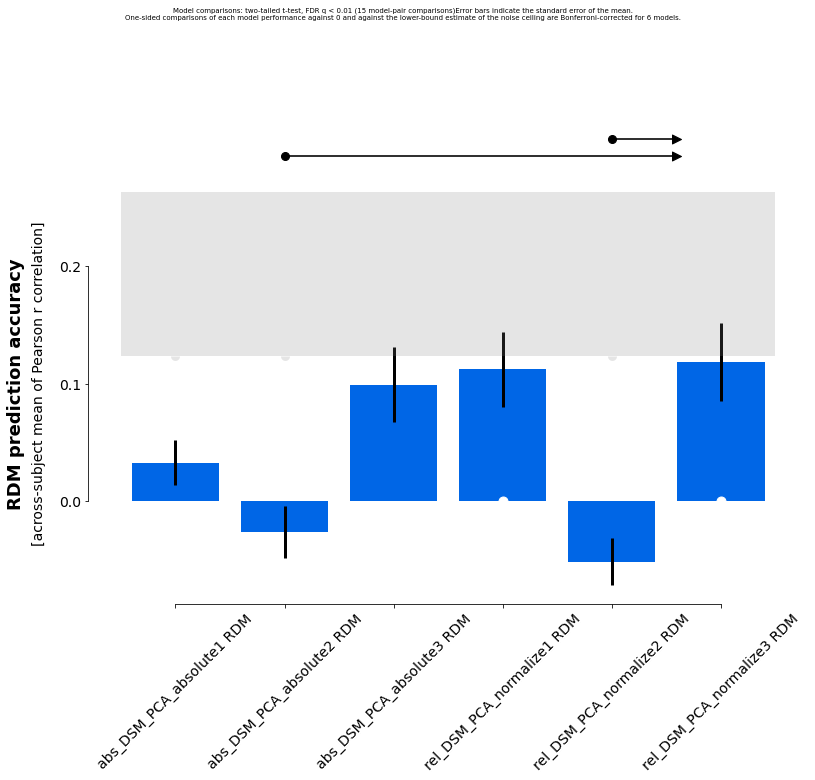

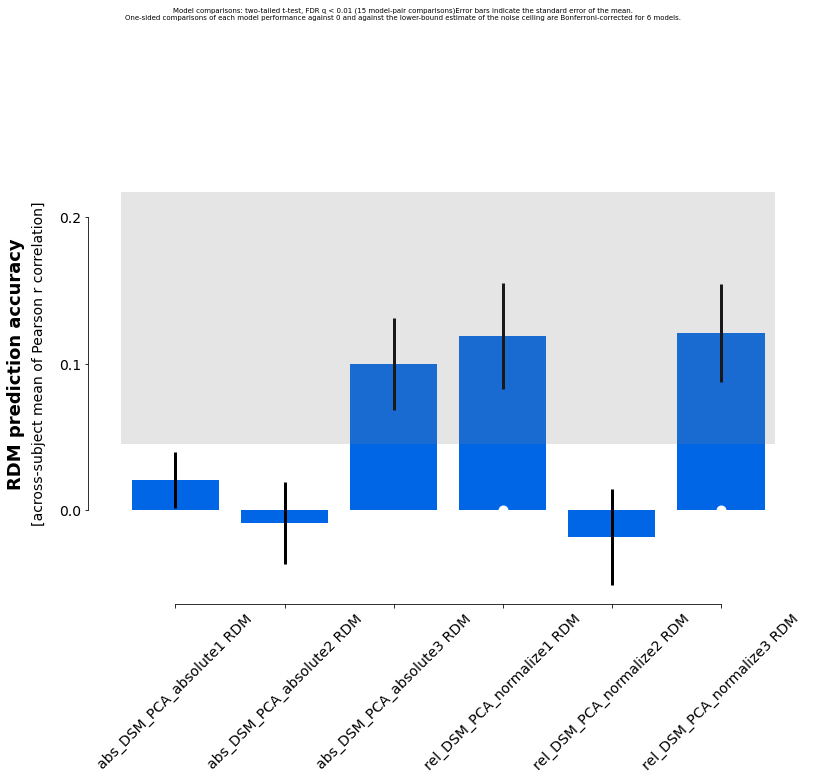

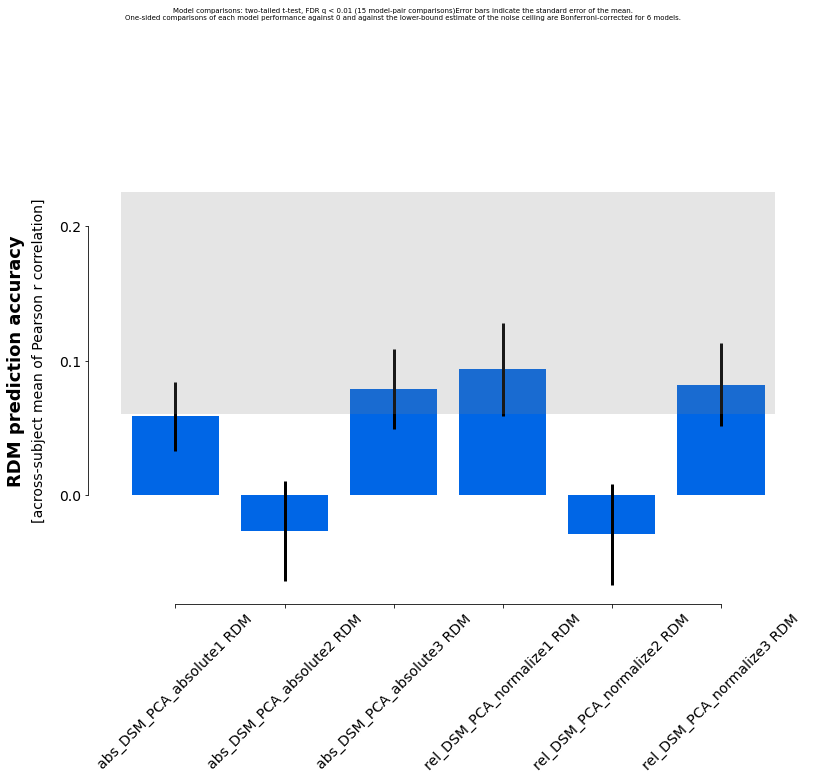

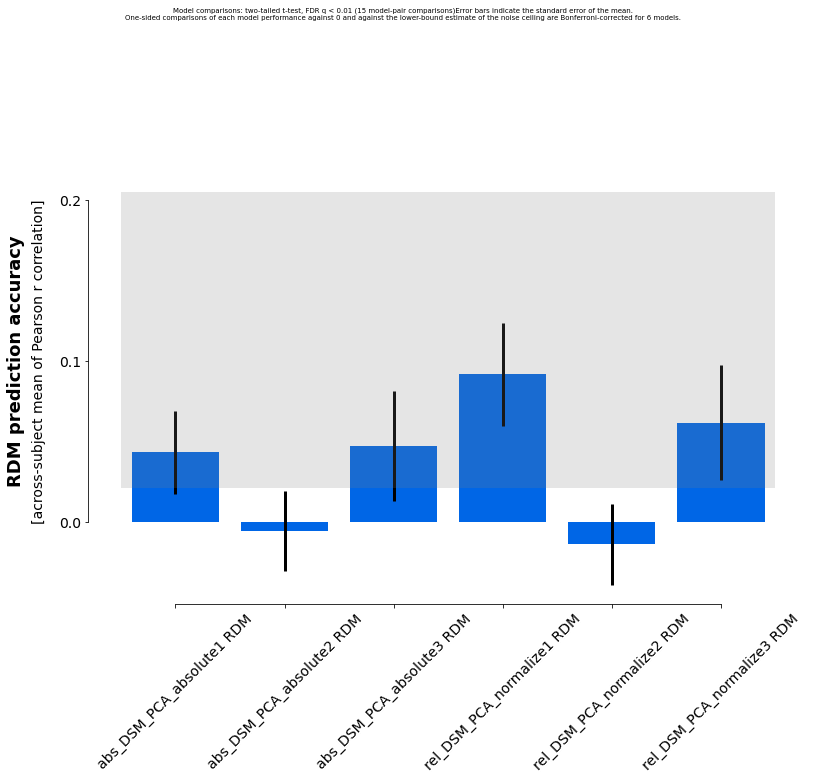

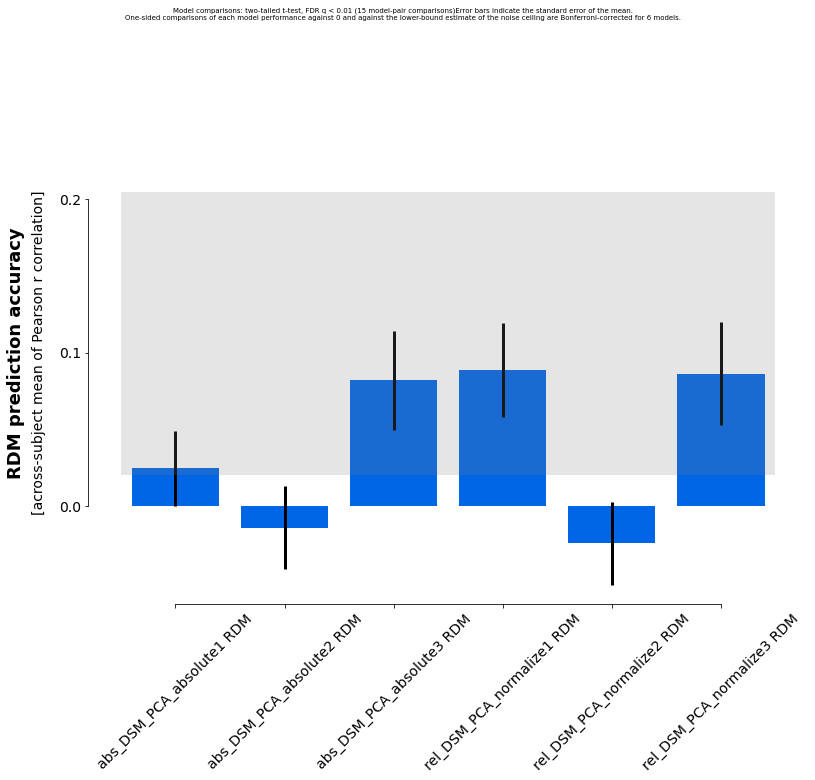

In [62]:
results_stim = []
fig = plt.figure()
for rx, roi in enumerate(mask_list):
    results_stim.append(rsatoolbox.inference.eval_fixed(stim_models, 
                                                     group_rdms.subset('ROI', value=roi), 
                                                     method='corr',))
    rsatoolbox.vis.plot_model_comparison(results_stim[rx])
    fig.axes.append(ax)

### Categorical model comparisons

In [72]:
results_1 = []
for roi in mask_list:
    print(roi)
    results_1.append(rsatoolbox.inference.eval_fixed(cat_models, 
                                                     group_rdms.subset('ROI', value=roi).subset('group', value='non-Mandarin'), 
                                                     method='corr',))


mask-L-IC
mask-L-MGN
mask-L-HG
mask-L-PP
mask-L-PT
mask-L-STGp
mask-L-STGa
mask-L-ParsOp
mask-L-ParsTri
mask-R-IC
mask-R-MGN
mask-R-HG
mask-R-PP
mask-R-PT
mask-R-STGp
mask-R-STGa
mask-R-ParsOp
mask-R-ParsTri


In [73]:
results_1[0].to_dict()

{'evaluations': array([[[ 0.08959093, -0.01847246, -0.01373171, -0.00644654,
           0.00860392,  0.16642903, -0.00759251,  0.11492752,
          -0.02063302,  0.10683466, -0.00948294,  0.09091043],
         [-0.05127814, -0.06705387,  0.12528086,  0.04186323,
           0.10918781,  0.06777679, -0.03954414, -0.04686484,
           0.00116636, -0.06937635, -0.07100476, -0.0345868 ]]]),
 'dof': 11,
 'variances': array([[ 3.70598473e-04, -5.06162943e-05],
        [-5.06162943e-05,  4.22748254e-04]]),
 'noise_ceiling': array([0.07998521, 0.32389848]),
 'method': 'corr',
 'cv_method': 'fixed',
 'models': {'model_0': {'rdm': {'dissimilarities': array([[0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
            0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
            1., 0., 0., 1., 1., 1., 1., 1., 1., 1

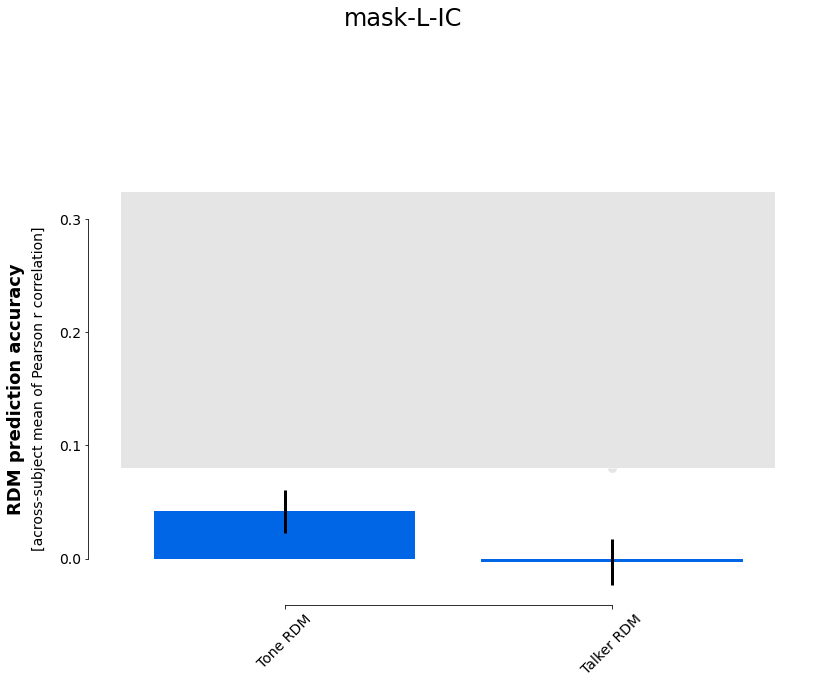

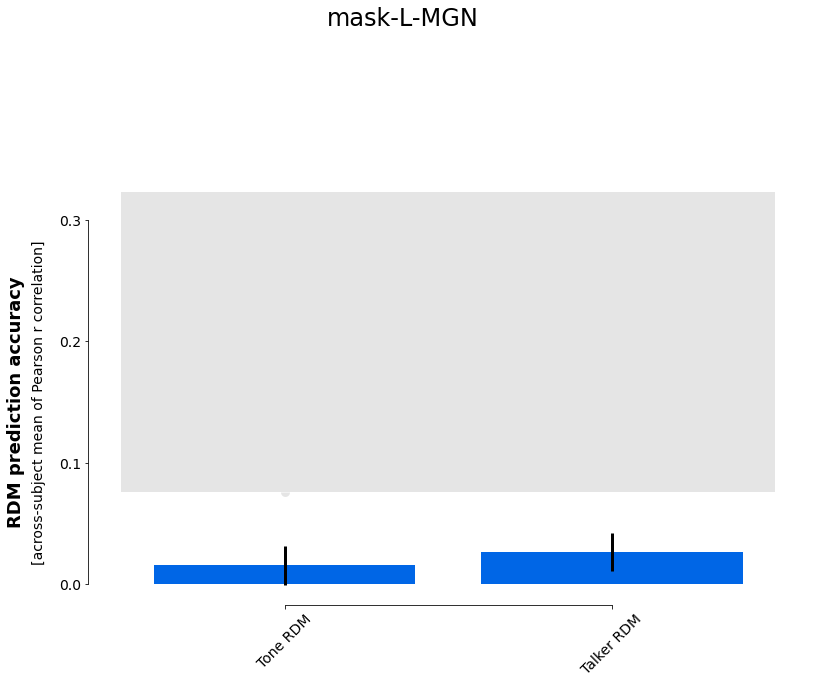

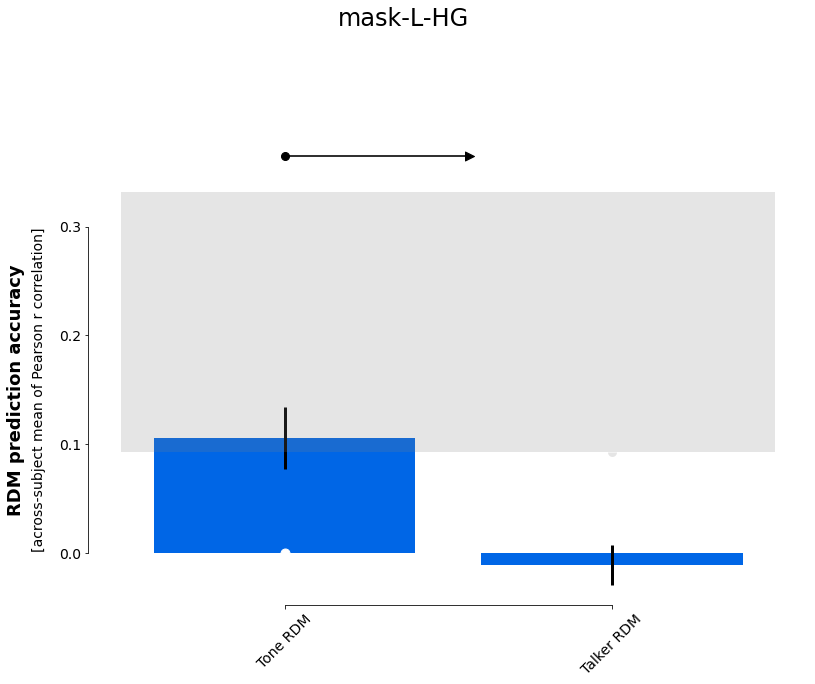

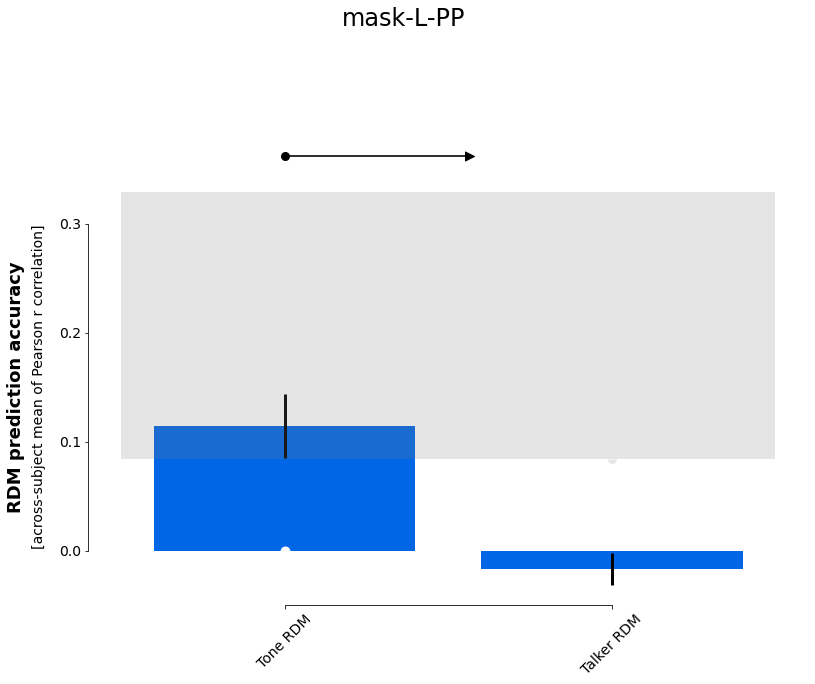

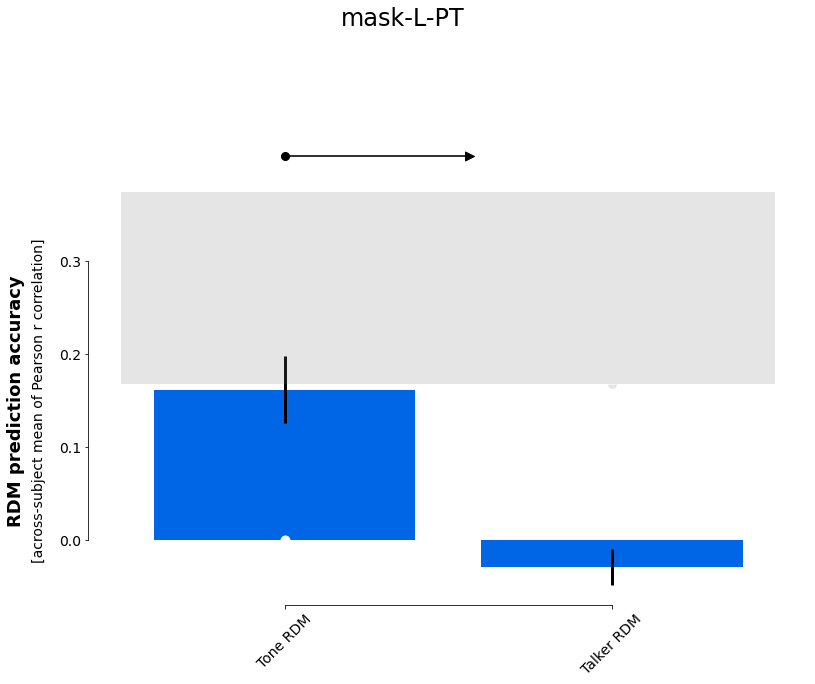

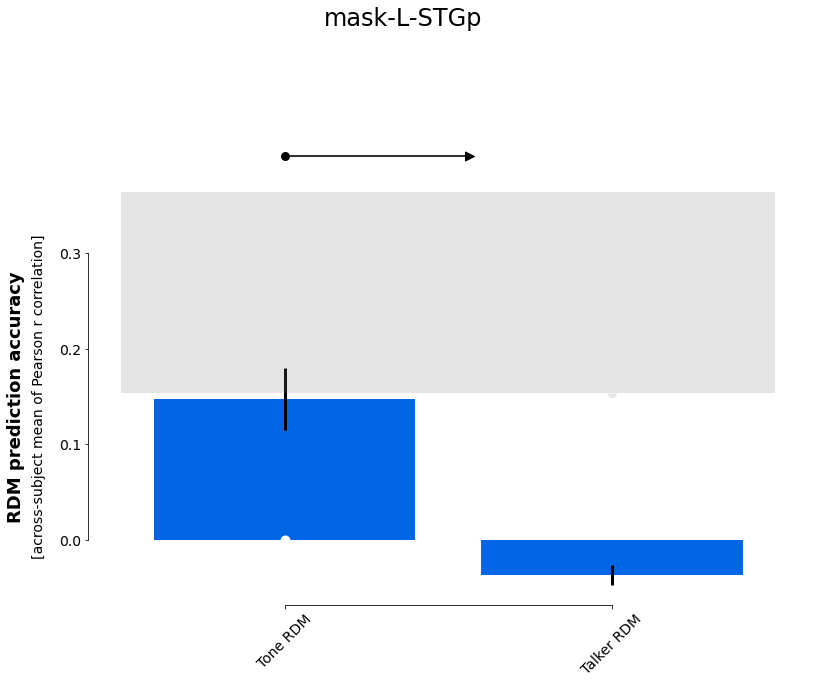

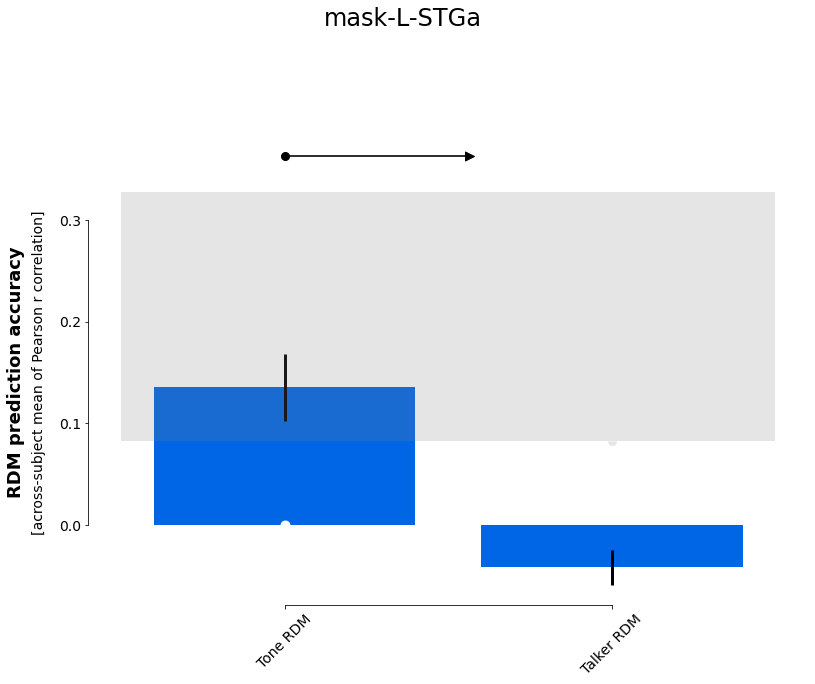

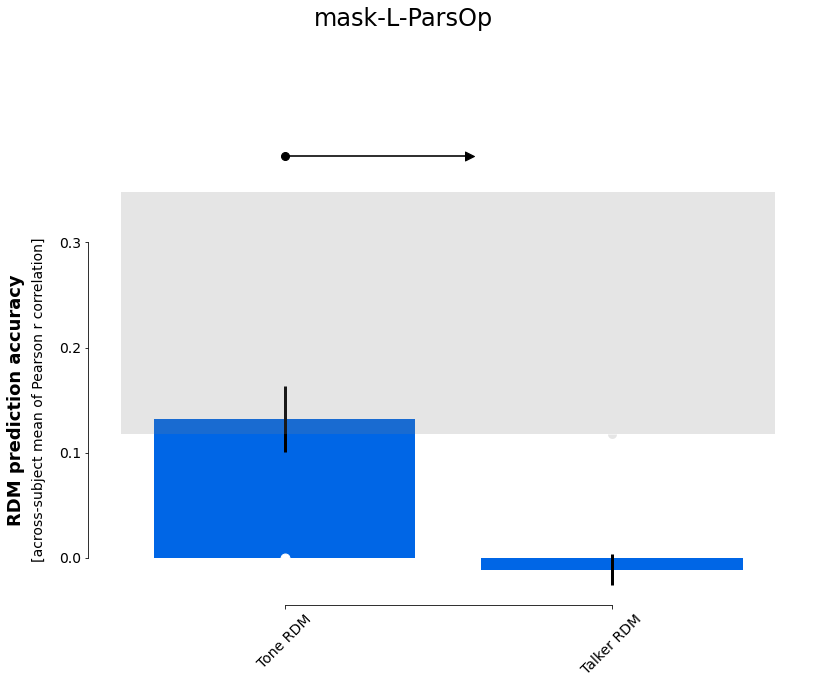

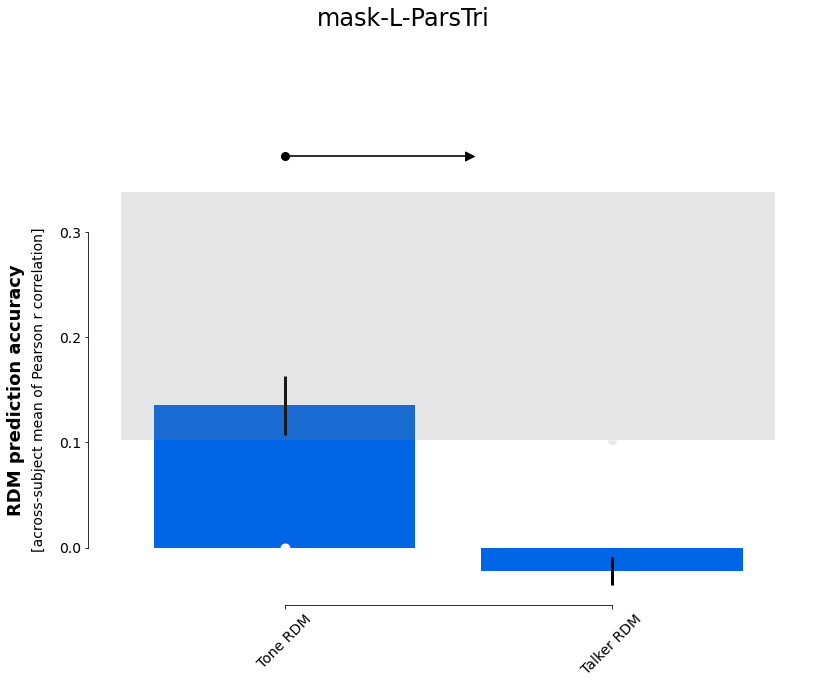

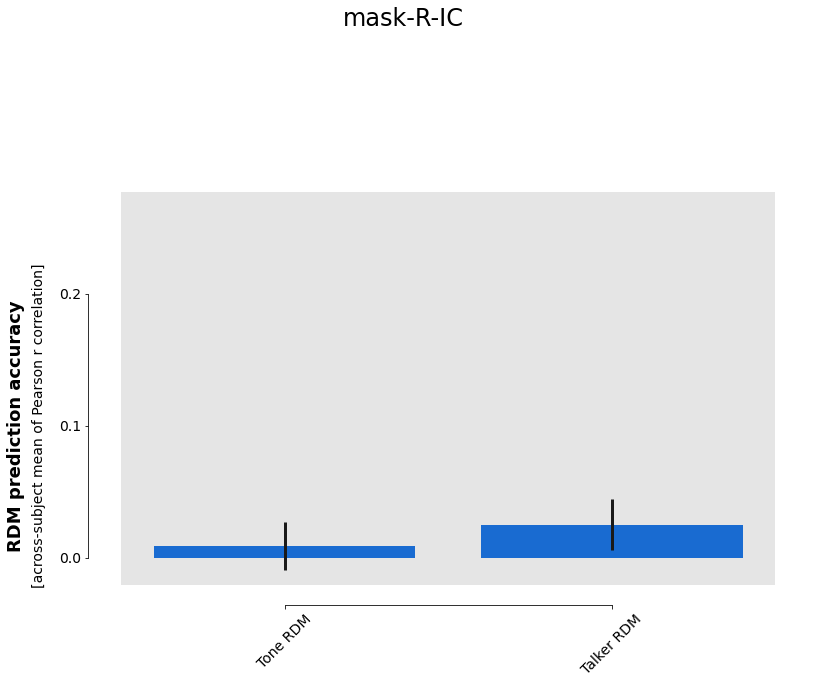

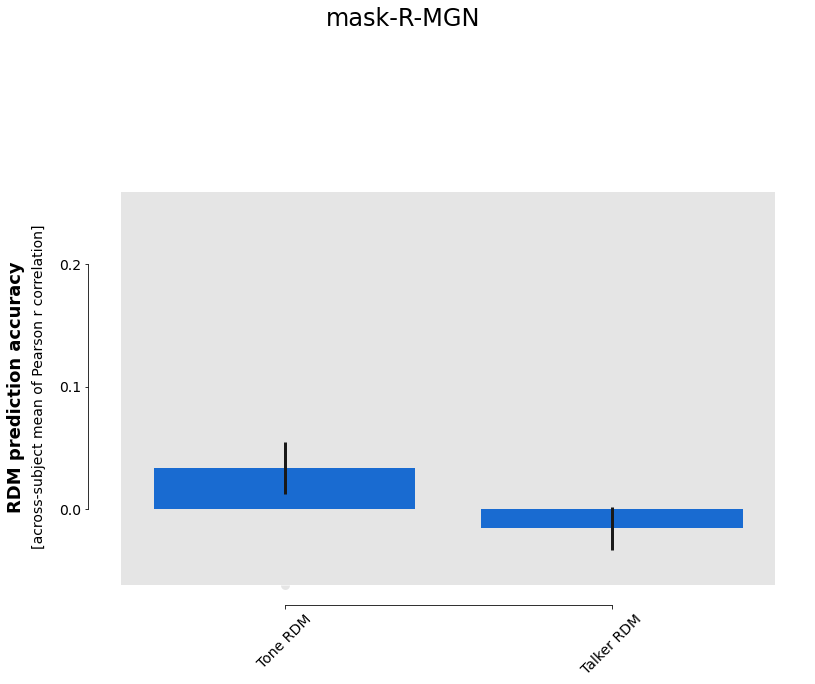

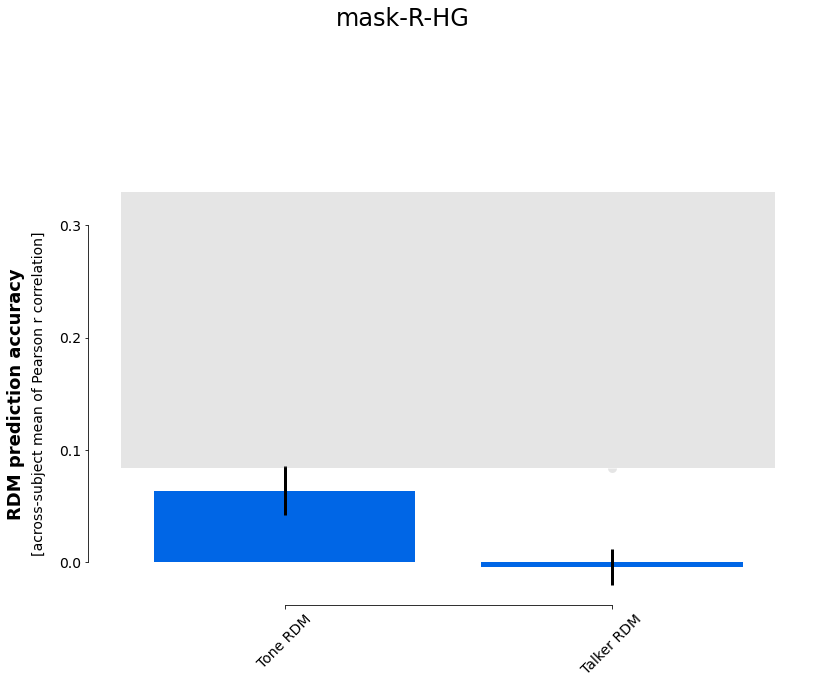

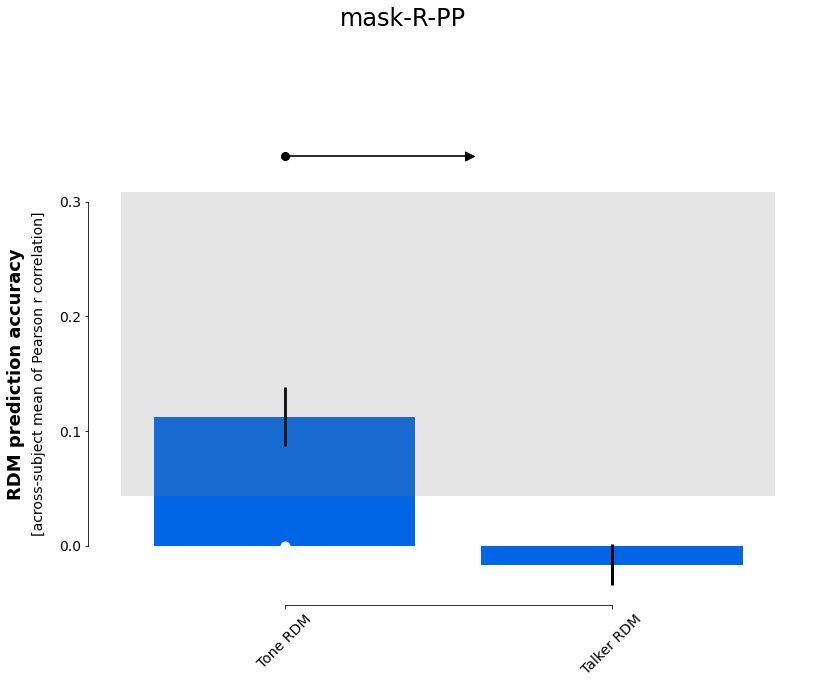

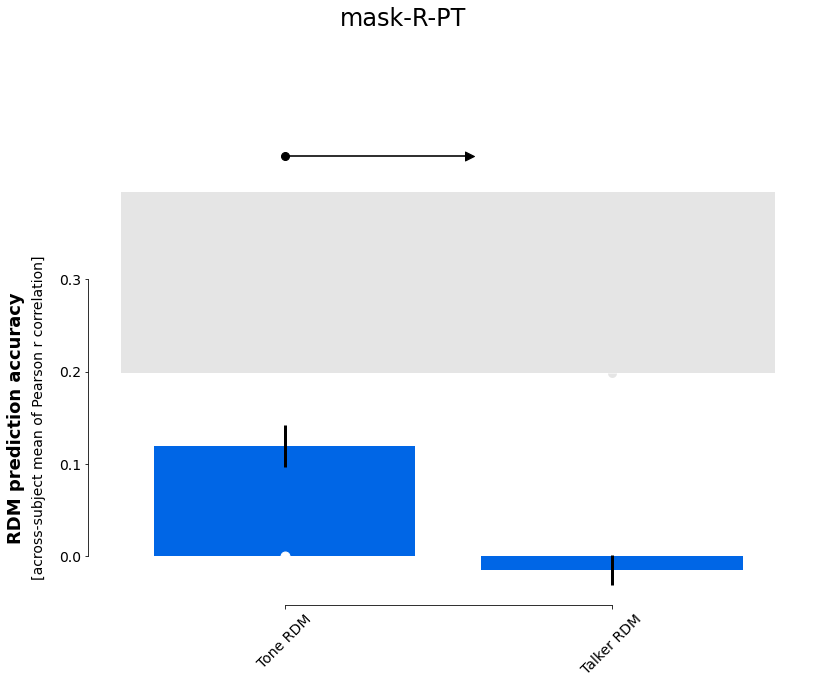

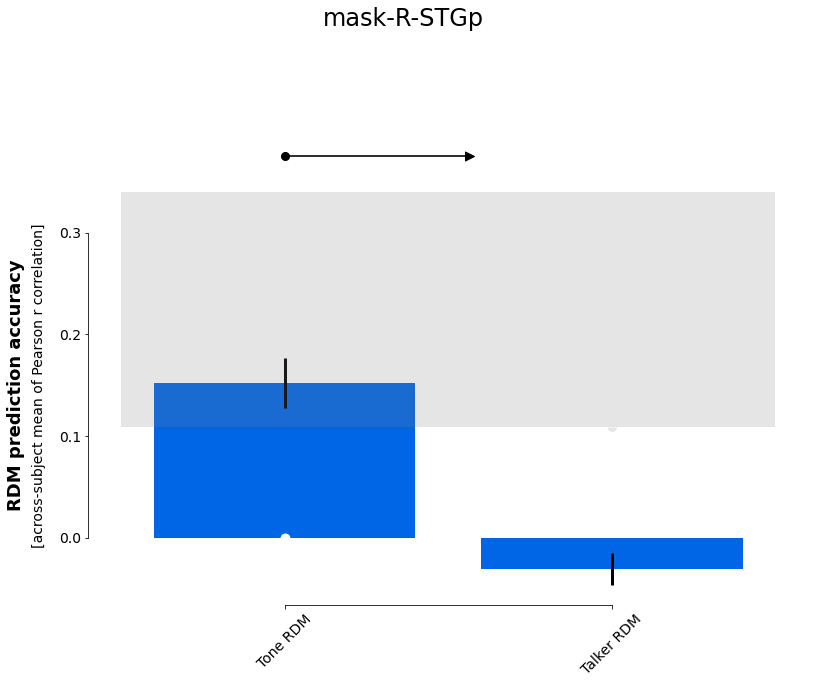

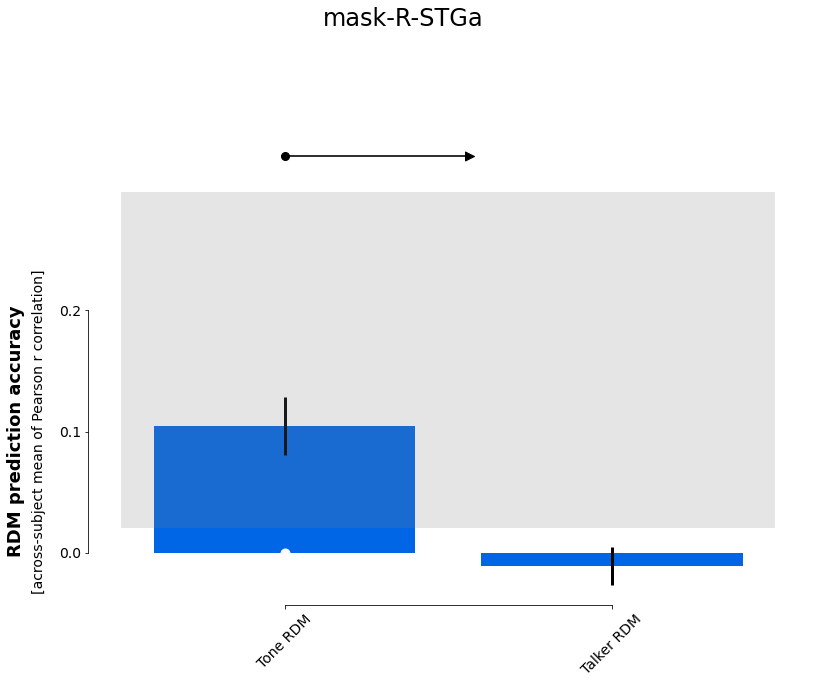

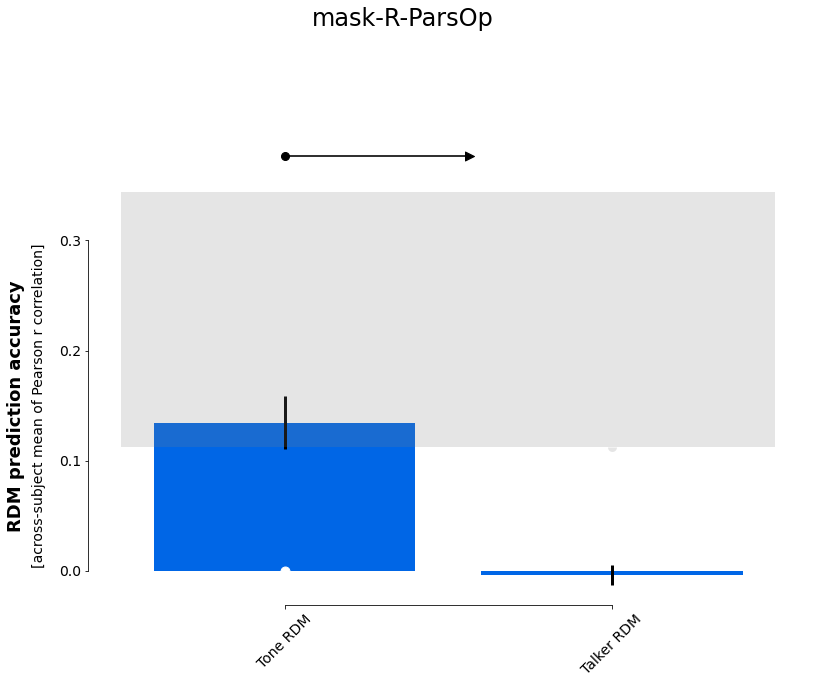

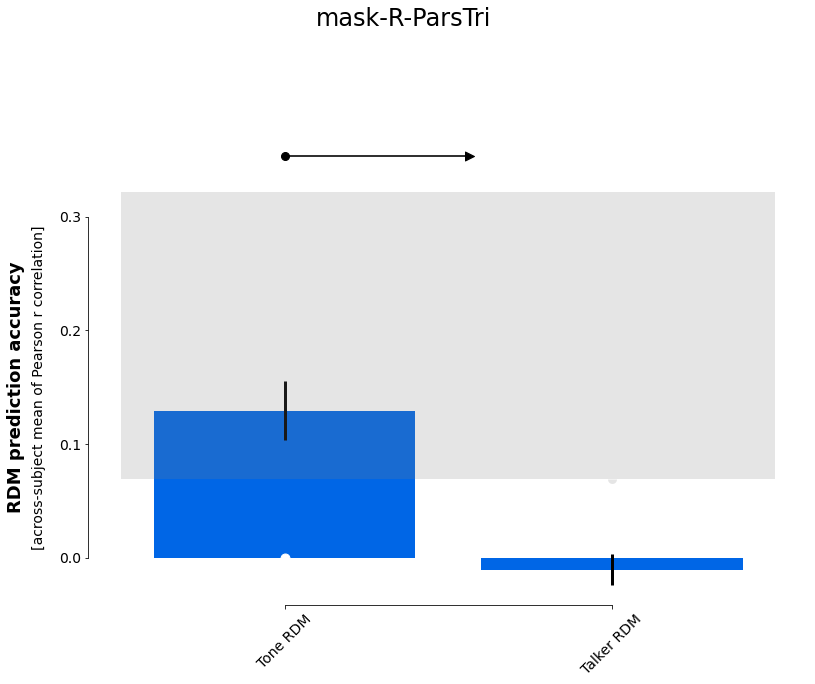

In [74]:
for rx, roi in enumerate(mask_list):
    fig = rsatoolbox.vis.plot_model_comparison(results_1[rx])
    fig[0].suptitle(roi, fontsize=24)

In [67]:
results_boot = rsatoolbox.inference.eval_dual_bootstrap(cat_models, group_rdms, rdm_descriptor='ROI')

100%|██████████| 1000/1000 [01:08<00:00, 14.56it/s]


(<Figure size 900x720 with 2 Axes>, <Axes: >, <Axes: >)

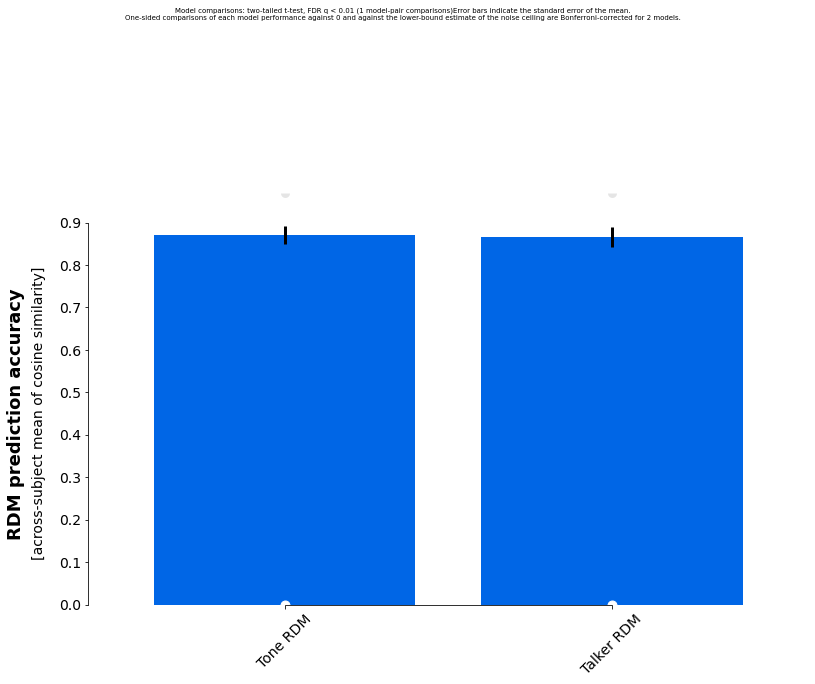

In [68]:
rsatoolbox.vis.plot_model_comparison(results_boot)